# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification, Regression and Cluster model

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* Generate a list with variables to engineer

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

# Load Cleaned Data

Train set

In [4]:
import pandas as pd

train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 4                47             0             21   
1  [60-70)                 3                50             1             11   
2  [50-60)                 4                66             1             10   

   n_outpatient  n_inpatient  n_emergency           diag_1       diag_2  \
0             0            1            0            Other        Other   
1             0            0            0  Musculoskeletal  Circulatory   
2             0            0            0            Other        Other   

     diag_3 glucose_test A1Ctest change diabetes_med  readmitted  
0     Other           no      no    yes          yes           1  
1  Diabetes           no      no     no           no           0  
2  Diabetes           no    high     no           no           0

Test set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 1                17             1              5   
1  [60-70)                 1                37             1             12   
2  [80-90)                 4                43             3             15   

   n_outpatient  n_inpatient  n_emergency       diag_1       diag_2  \
0             0            4            2  Respiratory        Other   
1             0            0            0        Other  Circulatory   
2             1            0            0    Digestive  Respiratory   

        diag_3 glucose_test A1Ctest change diabetes_med  readmitted  
0        Other       normal      no     no           no           1  
1  Respiratory           no      no     no          yes           1  
2     Diabetes           no      no     no          yes           1

---

# Feature engineering

### Custom Function

In [6]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser, DecisionTreeDiscretiser

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None, y=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'categorical_encoding', 'outlier_winsorizer', 'discretisation']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column, y=y)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]
    
    elif analysis_type == 'discretisation':
        list_column_transformers = ["equal_freq", "equal_width", "decision_tree"]

    elif analysis_type == 'categorical_encoding':
        list_column_transformers = ["ordinal_encoder", "one_hot_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr', 'gaussian']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column, y=None):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)
    
    elif analysis_type == 'discretisation':
        df_feat_eng, list_applied_transformers = FeatEngineering_Discretisation(
            df_feat_eng, column, y=y)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'categorical_encoding':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'categorical_encoding':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []

    # OrdinalEncoder
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")
    except Exception as e:
        print(f"OrdinalEncoder failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer with IQR
    try:
        if df_feat_eng[column].nunique() > 1:  # Check for variation in the original column
            disc = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[column])
            df_feat_eng[f"{column}_iqr"] = disc.fit_transform(df_feat_eng[[column]])
            list_methods_worked.append(f"{column}_iqr")
        else:
            print(f"Skipping Winsorizer (IQR) for {column} due to low variation.")
    except Exception as e:
        print(f"Winsorizer (IQR) failed for {column}: {e}")
        if f"{column}_iqr" in df_feat_eng.columns:
            df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    # Winsorizer with Gaussian method
    try:
        disc = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=[column])
        df_feat_eng[f"{column}_gaussian"] = disc.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_gaussian")
    except Exception as e:
        print(f"Winsorizer (Gaussian) failed for {column}: {e}")
        if f"{column}_gaussian" in df_feat_eng.columns:
            df_feat_eng.drop([f"{column}_gaussian"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Discretisation(df_feat_eng, column, y):
    list_methods_worked = []

    # EqualFrequencyDiscretiser
    try:
        disc = EqualFrequencyDiscretiser(
            q=10, variables=[f"{column}_equal_freq"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_equal_freq")
    except Exception as e:
        print(f"EqualFrequencyDiscretiser failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_equal_freq"], axis=1, inplace=True)

    # EqualWidthDiscretiser
    try:
        disc = EqualWidthDiscretiser(
            bins=10, variables=[f"{column}_equal_width"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_equal_width")
    except Exception as e:
        print(f"EqualWidthDiscretiser failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_equal_width"], axis=1, inplace=True)
    
    # DecisionTreeDiscretiser
    try:
        disc = DecisionTreeDiscretiser(
            cv=3, scoring='accuracy', variables=[f"{column}_decision_tree"],
            regression=False)
        df_feat_eng = disc.fit_transform(df_feat_eng, y)
        list_methods_worked.append(f"{column}_decision_tree")
    except Exception as e:
        print(f"DecisionTreeDiscretiser failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_decision_tree"], axis=1, inplace=True)
            
    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception as e:
        print(f"LogTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception as e:
        print(f"LogTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception as e:
        print(f"ReciprocalTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception as e:
        print(f"PowerTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception as e:
        print(f"BoxCoxTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception as e:
        print(f"YeoJohnsonTransformer failed for {column}: {e}")
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Categorical encoding

In [7]:
categorical_variables = ['age', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
categorical_variables

['age',
 'diag_1',
 'diag_2',
 'diag_3',
 'glucose_test',
 'A1Ctest',
 'change',
 'diabetes_med']

In [8]:
df_cat_engineering =TrainSet[categorical_variables].copy()
df_cat_engineering.head()

age           diag_1       diag_2    diag_3 glucose_test A1Ctest  \
0  [70-80)            Other        Other     Other           no      no   
1  [60-70)  Musculoskeletal  Circulatory  Diabetes           no      no   
2  [50-60)            Other        Other  Diabetes           no    high   
3  [50-60)      Respiratory  Circulatory  Diabetes       normal      no   
4  [50-60)            Other     Diabetes     Other           no      no   

  change diabetes_med  
0    yes          yes  
1     no           no  
2     no           no  
3     no          yes  
4    yes          yes

* Variable Analyzed: age
* Applied transformation: ['age_ordinal_encoder'] 



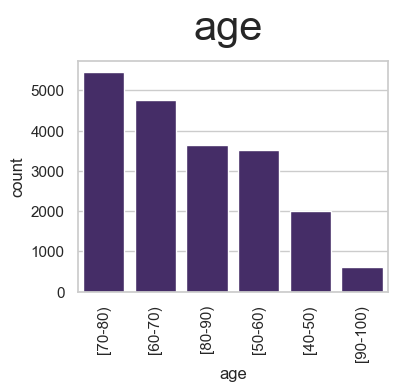

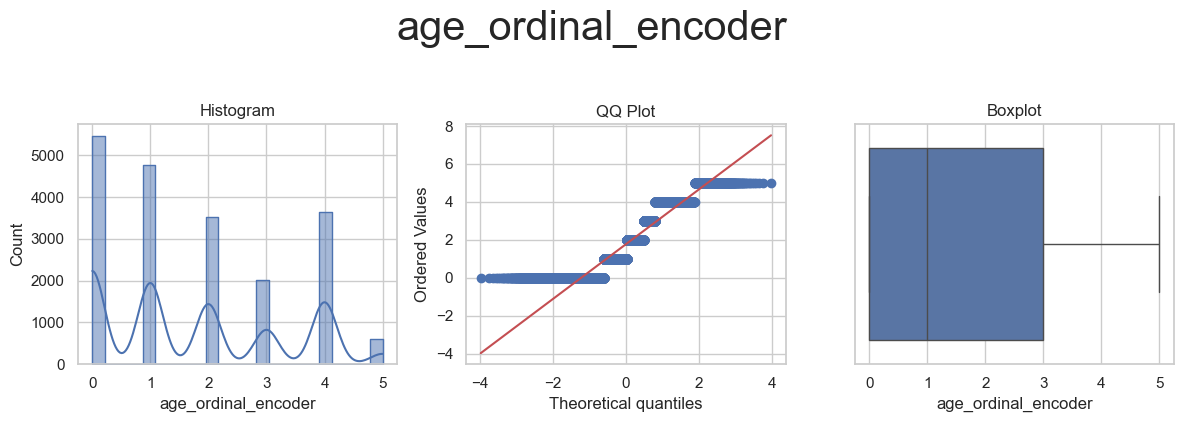



* Variable Analyzed: diag_1
* Applied transformation: ['diag_1_ordinal_encoder'] 



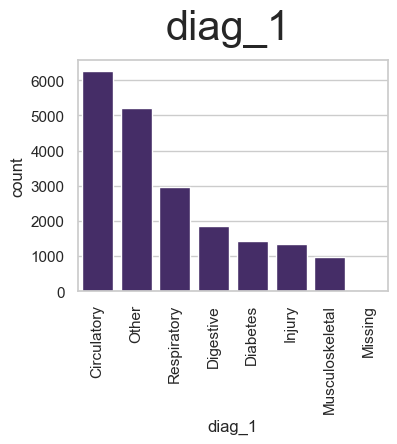

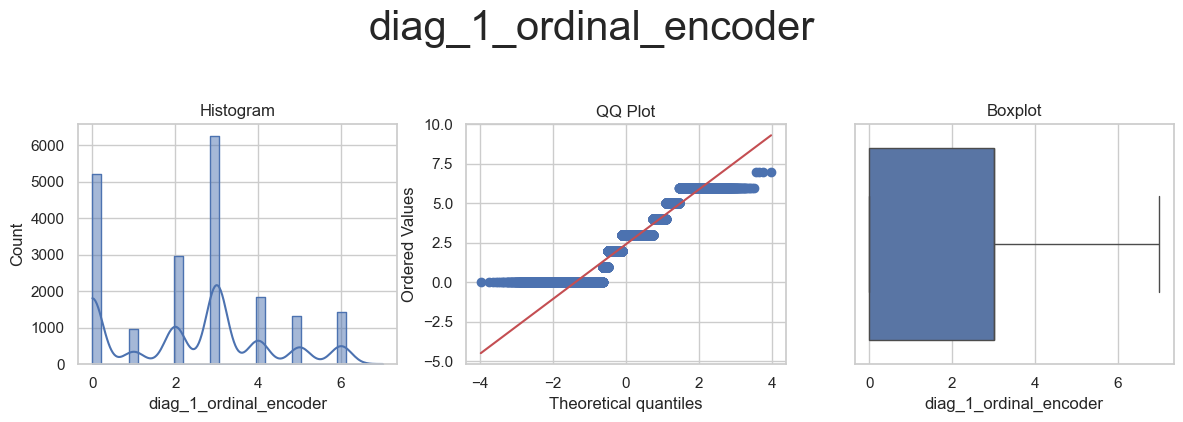



* Variable Analyzed: diag_2
* Applied transformation: ['diag_2_ordinal_encoder'] 



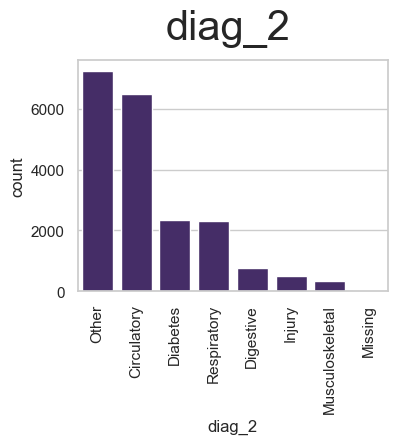

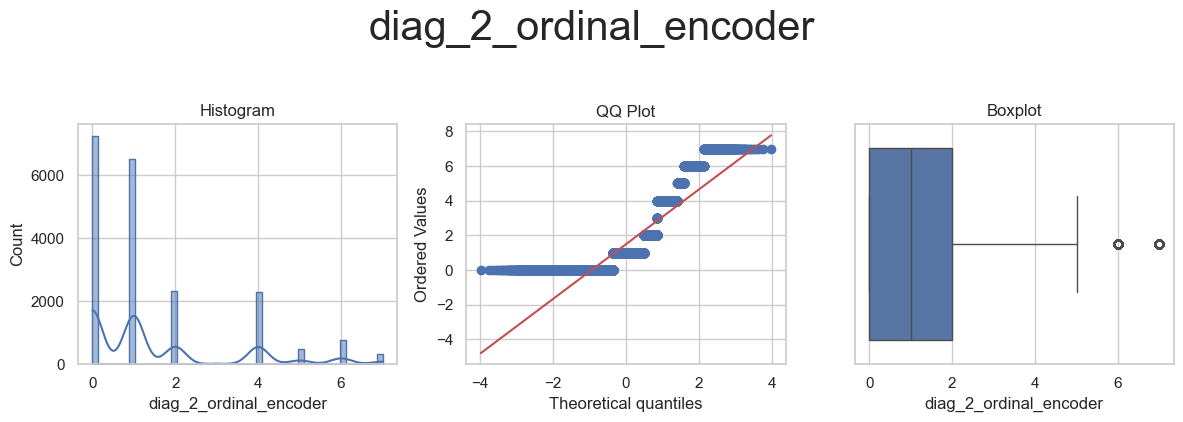



* Variable Analyzed: diag_3
* Applied transformation: ['diag_3_ordinal_encoder'] 



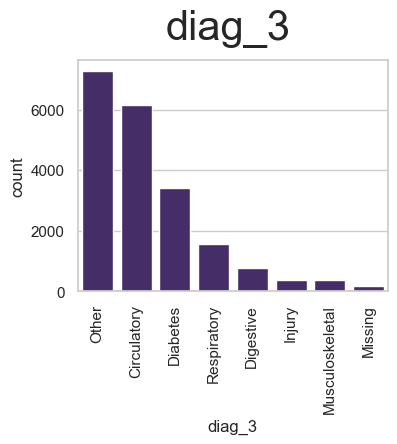

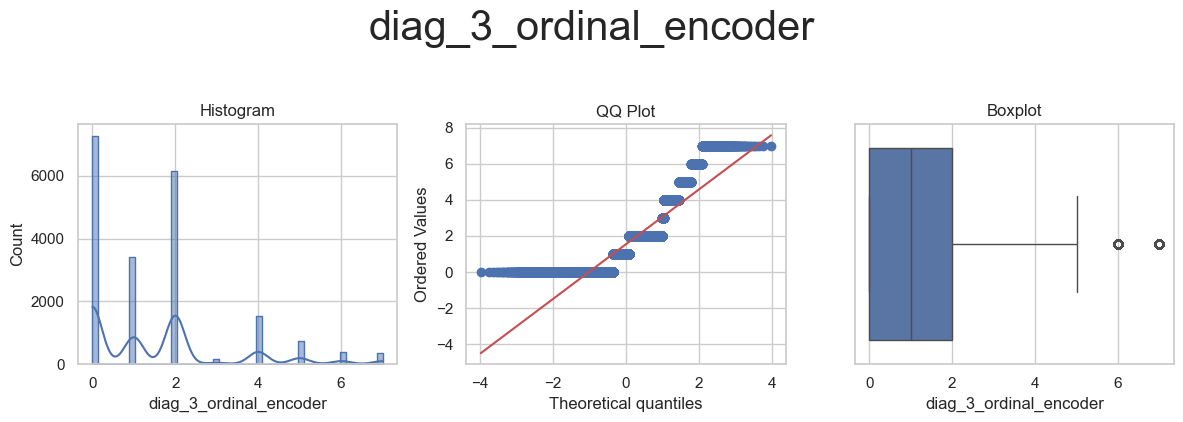



* Variable Analyzed: glucose_test
* Applied transformation: ['glucose_test_ordinal_encoder'] 



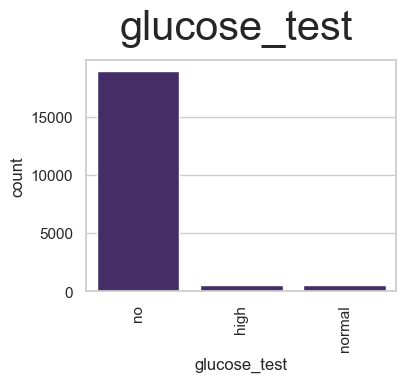

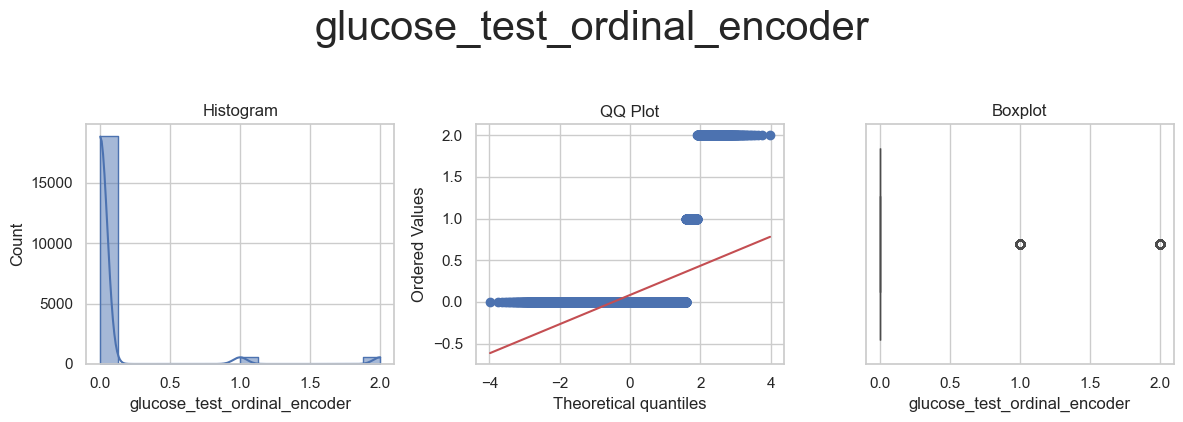



* Variable Analyzed: A1Ctest
* Applied transformation: ['A1Ctest_ordinal_encoder'] 



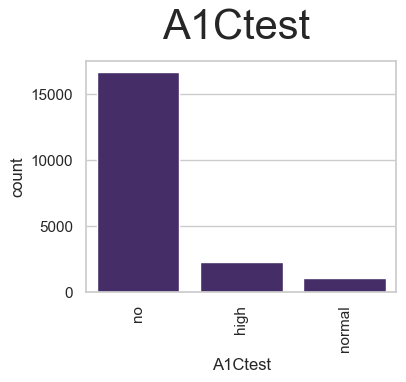

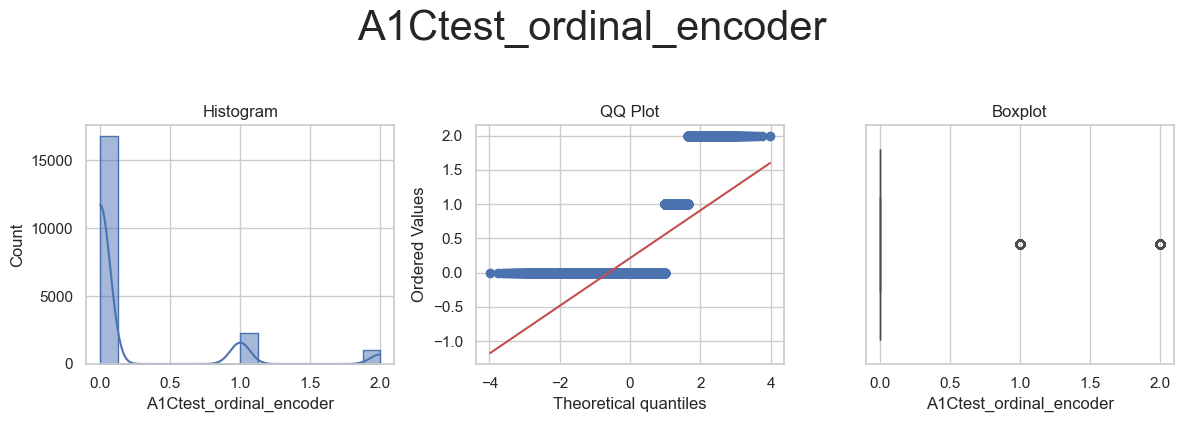



* Variable Analyzed: change
* Applied transformation: ['change_ordinal_encoder'] 



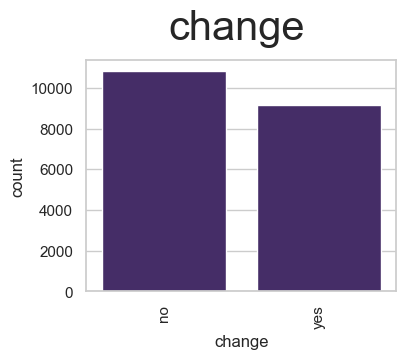

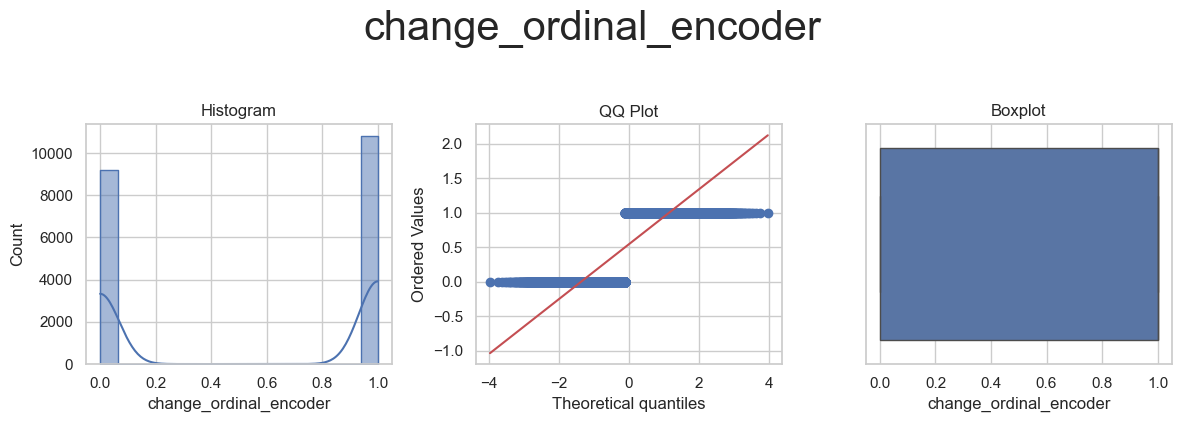



* Variable Analyzed: diabetes_med
* Applied transformation: ['diabetes_med_ordinal_encoder'] 



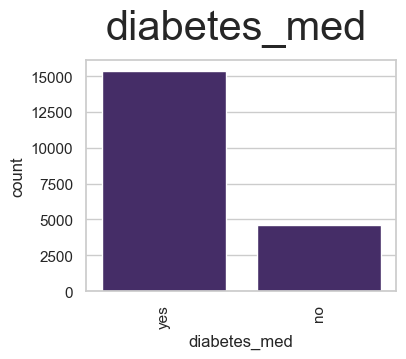

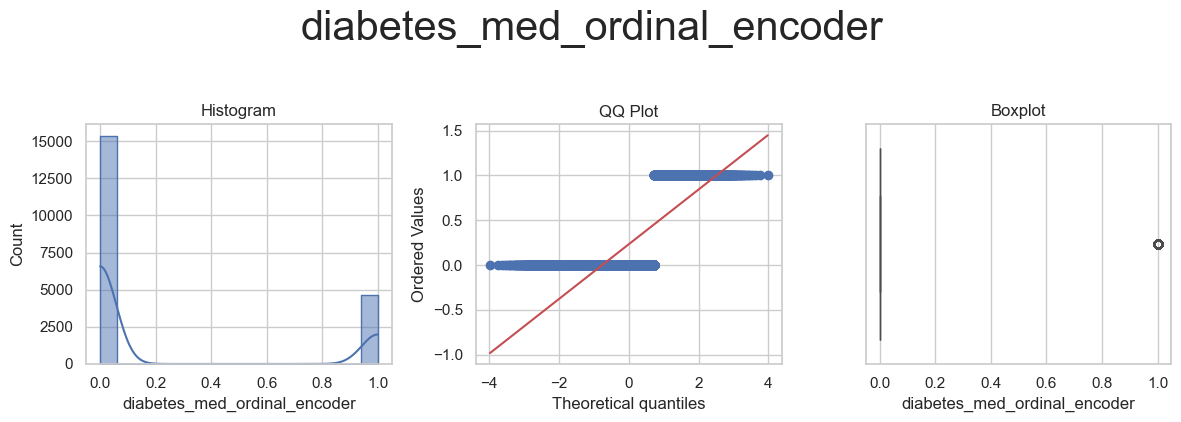

In [9]:
df_engineering = FeatureEngineeringAnalysis(df_cat_engineering, analysis_type='categorical_encoding')

## Numerical encoding

In [10]:
numerical_variables = ['time_in_hospital', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
numerical_variables

['time_in_hospital',
 'n_procedures',
 'n_medications',
 'n_outpatient',
 'n_inpatient',
 'n_emergency']

In [11]:
df_num_engineering = TestSet[numerical_variables].copy()
df_num_engineering.head()

time_in_hospital  n_procedures  n_medications  n_outpatient  n_inpatient  \
0                 1             1              5             0            4   
1                 1             1             12             0            0   
2                 4             3             15             1            0   
3                 3             0             13             0            5   
4                 5             0             11             0            1   

   n_emergency  
0            2  
1            0  
2            0  
3            0  
4            0

* Variable Analyzed: time_in_hospital
* Applied transformation: ['time_in_hospital_iqr', 'time_in_hospital_gaussian'] 



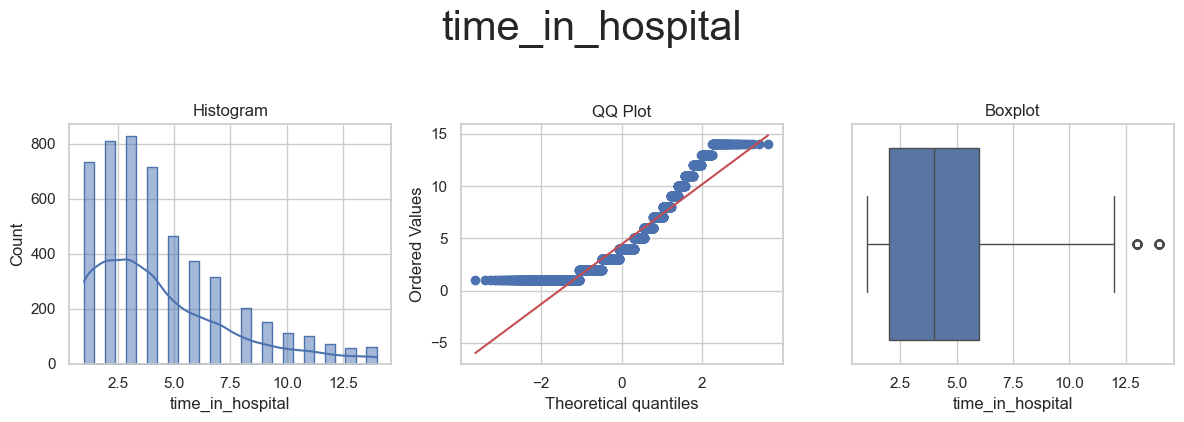

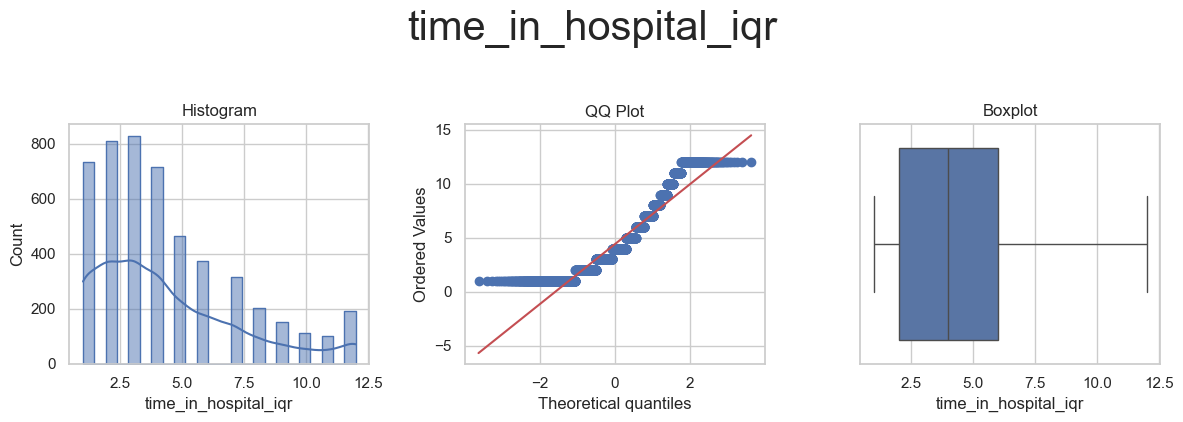

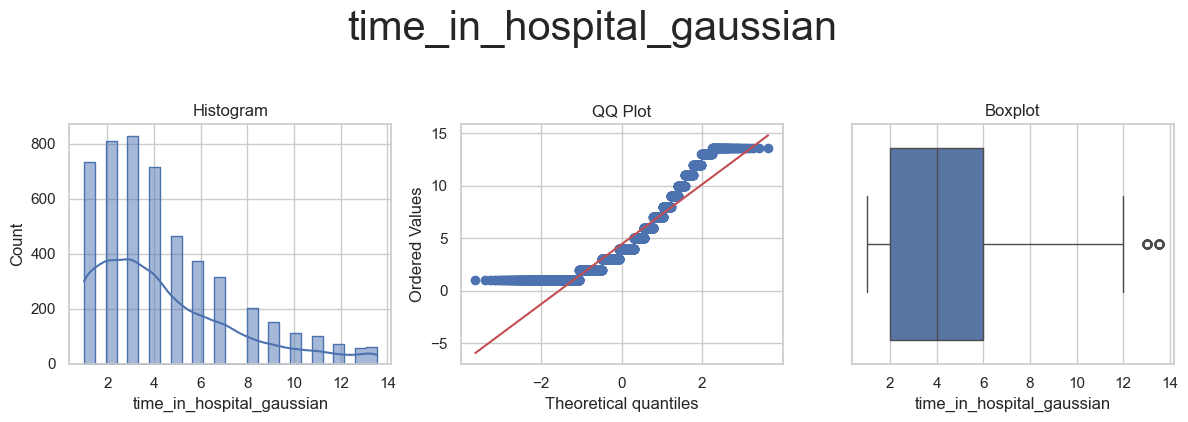



* Variable Analyzed: n_procedures
* Applied transformation: ['n_procedures_iqr', 'n_procedures_gaussian'] 



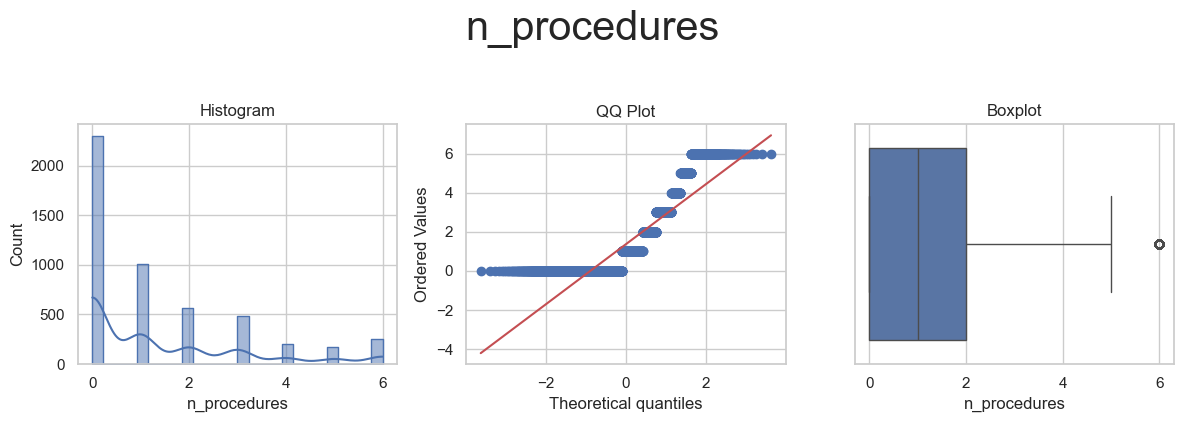

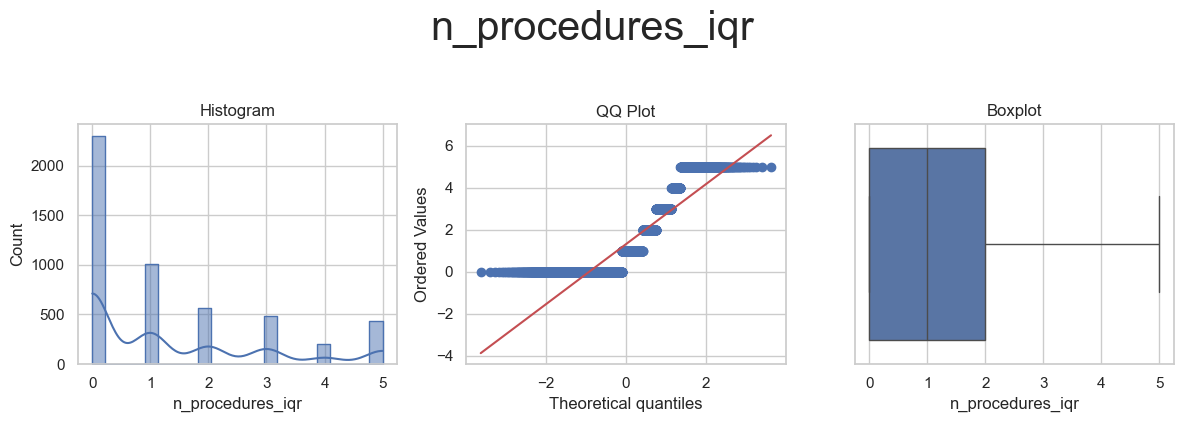

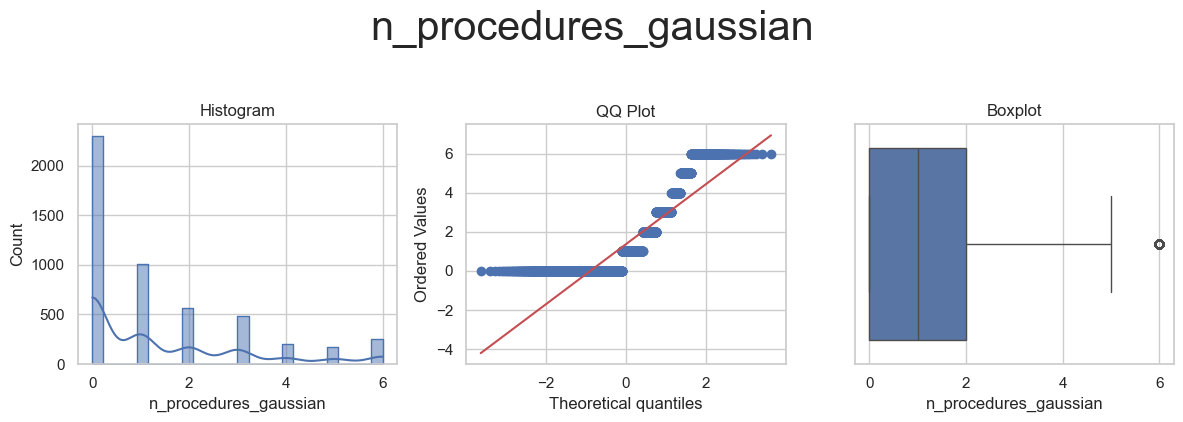



* Variable Analyzed: n_medications
* Applied transformation: ['n_medications_iqr', 'n_medications_gaussian'] 



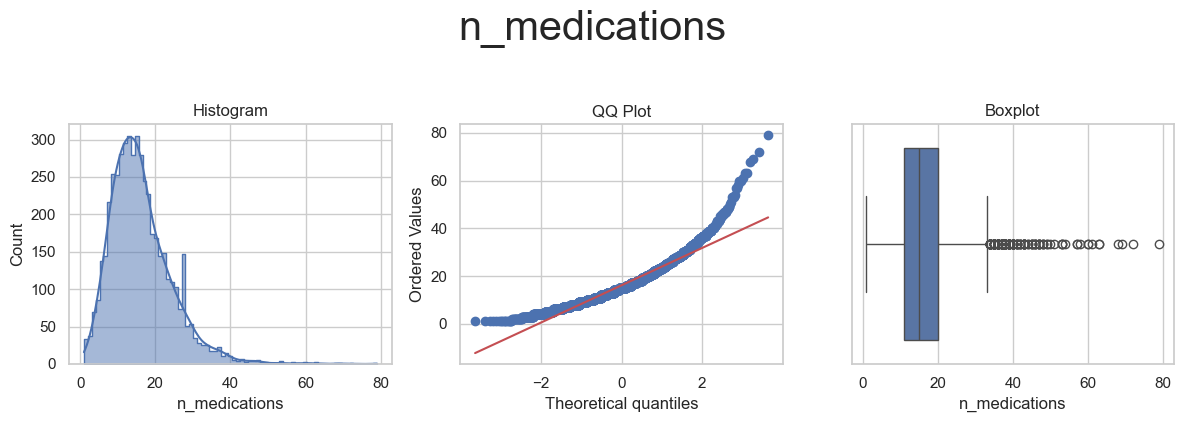

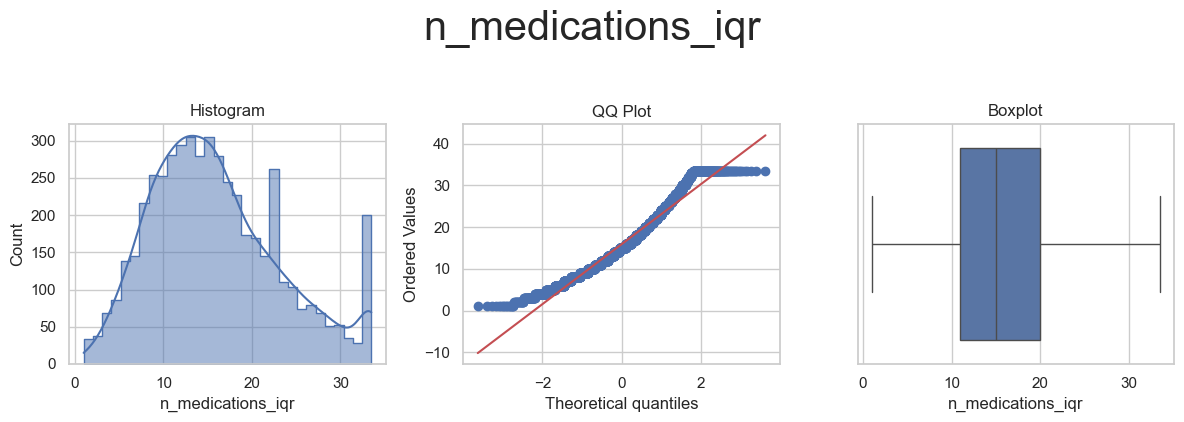

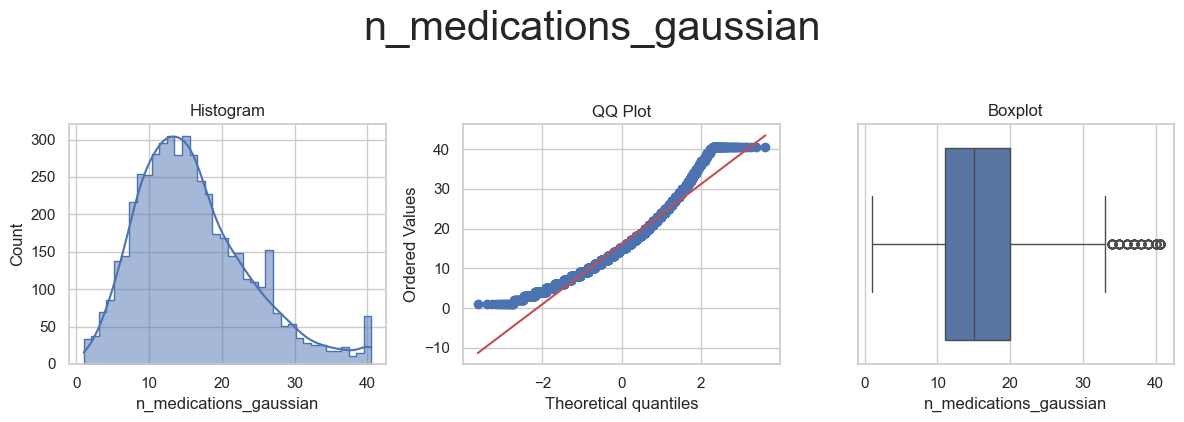



Winsorizer (IQR) failed for n_outpatient: Input columns ['n_outpatient'] have low variation for method 'iqr'. Try other capping methods or drop these columns.
* Variable Analyzed: n_outpatient
* Applied transformation: ['n_outpatient_gaussian'] 



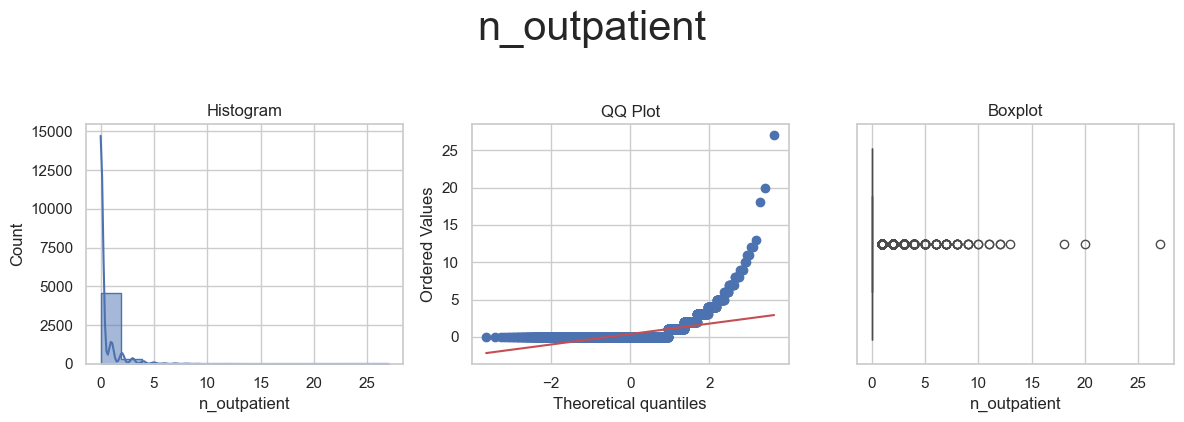

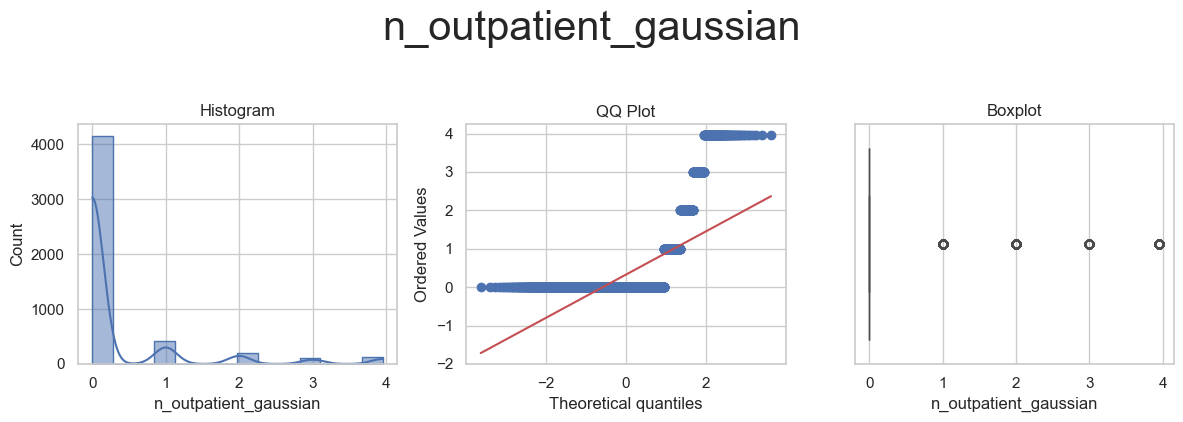



* Variable Analyzed: n_inpatient
* Applied transformation: ['n_inpatient_iqr', 'n_inpatient_gaussian'] 



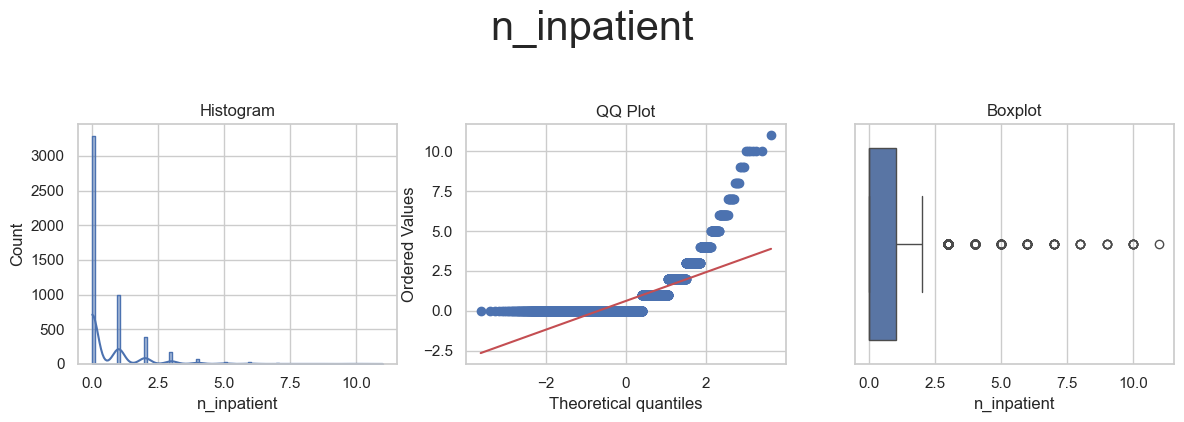

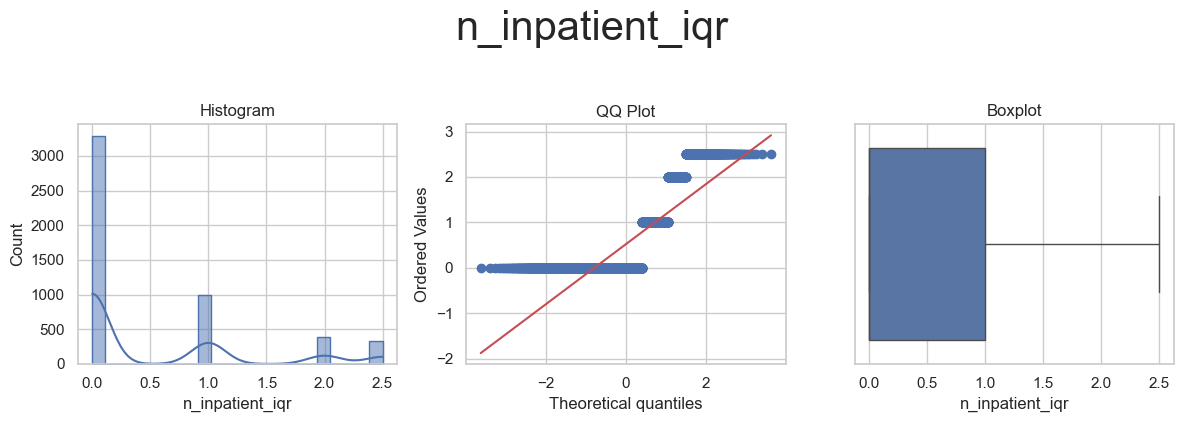

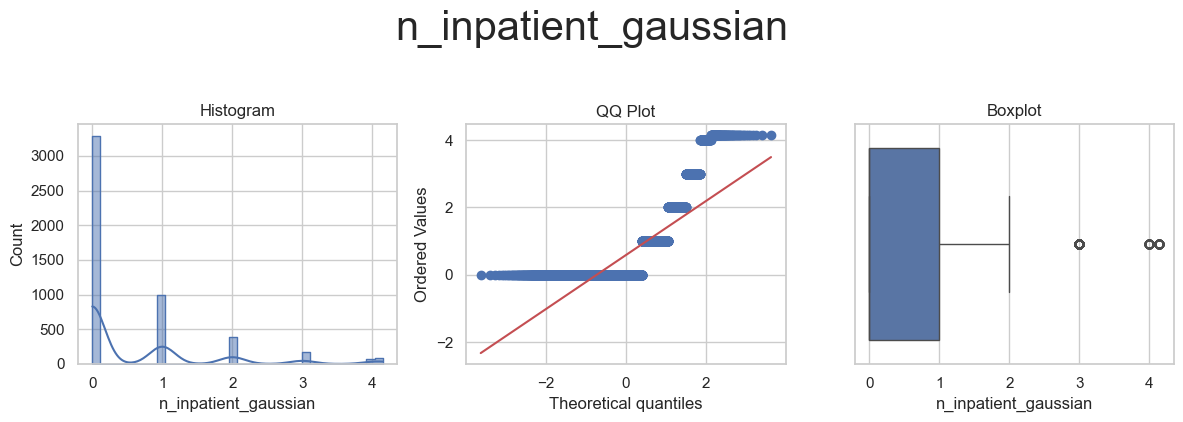



Winsorizer (IQR) failed for n_emergency: Input columns ['n_emergency'] have low variation for method 'iqr'. Try other capping methods or drop these columns.
* Variable Analyzed: n_emergency
* Applied transformation: ['n_emergency_gaussian'] 



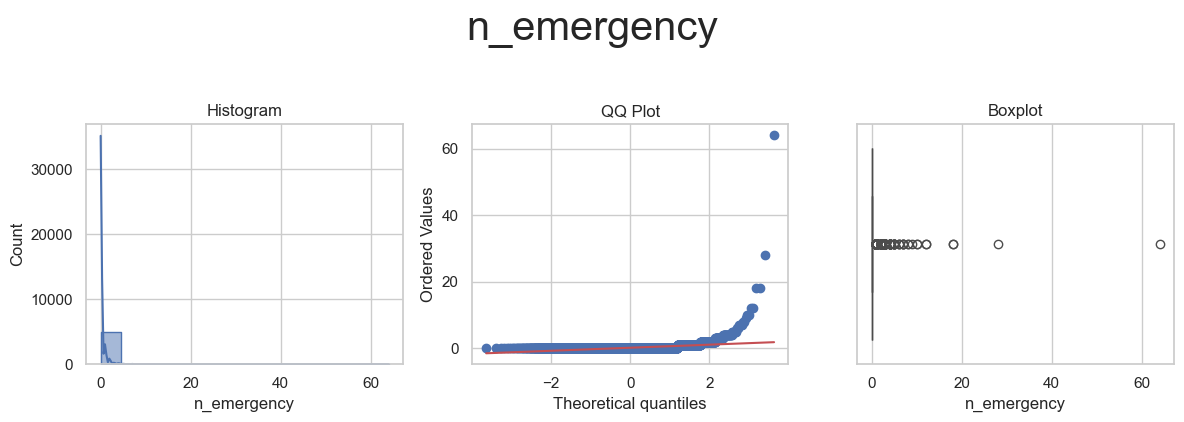

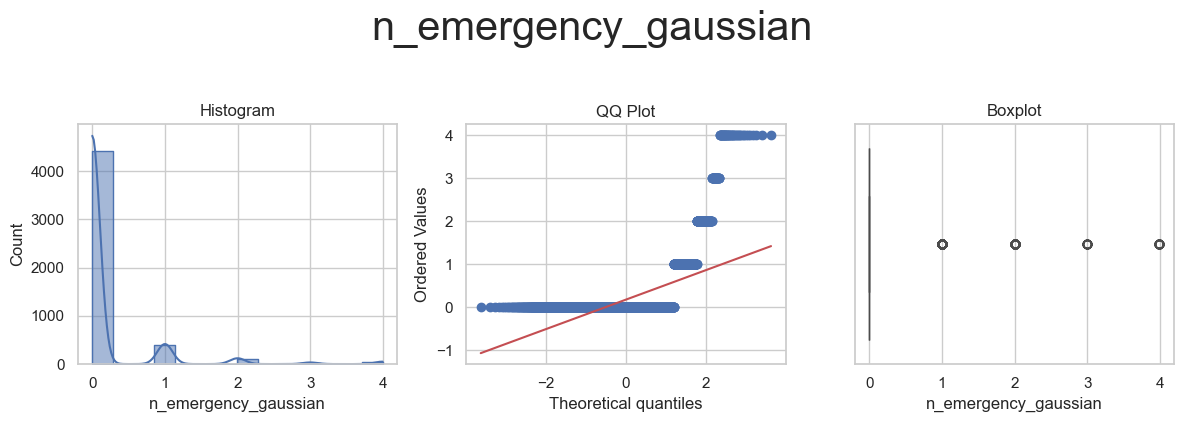

In [12]:
df_outliers_eng = FeatureEngineeringAnalysis(df_num_engineering, analysis_type='outlier_winsorizer')

In [13]:
df_outliers_after_eng = pd.DataFrame([])

for column in df_outliers_eng.columns:
        if column.endswith('_iqr'):
            df_outliers_after_eng[column] = df_outliers_eng[column]

df_outliers_after_eng.head()
            

time_in_hospital_iqr  n_procedures_iqr  n_medications_iqr  n_inpatient_iqr
0                     1                 1                5.0              2.5
1                     1                 1               12.0              0.0
2                     4                 3               15.0              0.0
3                     3                 0               13.0              2.5
4                     5                 0               11.0              1.0

In [14]:
df_outliers_after_eng[['n_emergency_gaussian', 'n_outpatient_gaussian']] = df_outliers_eng[['n_emergency_gaussian', 'n_outpatient_gaussian']]
df_outliers_after_eng.head()

time_in_hospital_iqr  n_procedures_iqr  n_medications_iqr  n_inpatient_iqr  \
0                     1                 1                5.0              2.5   
1                     1                 1               12.0              0.0   
2                     4                 3               15.0              0.0   
3                     3                 0               13.0              2.5   
4                     5                 0               11.0              1.0   

   n_emergency_gaussian  n_outpatient_gaussian  
0                   2.0                    0.0  
1                   0.0                    0.0  
2                   0.0                    1.0  
3                   0.0                    0.0  
4                   0.0                    0.0

In [15]:
df_num_discr = df_outliers_after_eng.copy()
df_num_discr['readmitted'] = TestSet['readmitted']
df_num_discr.head()

time_in_hospital_iqr  n_procedures_iqr  n_medications_iqr  n_inpatient_iqr  \
0                     1                 1                5.0              2.5   
1                     1                 1               12.0              0.0   
2                     4                 3               15.0              0.0   
3                     3                 0               13.0              2.5   
4                     5                 0               11.0              1.0   

   n_emergency_gaussian  n_outpatient_gaussian  readmitted  
0                   2.0                    0.0           1  
1                   0.0                    0.0           1  
2                   0.0                    1.0           1  
3                   0.0                    0.0           0  
4                   0.0                    0.0           1

* Variable Analyzed: time_in_hospital_iqr
* Applied transformation: ['time_in_hospital_iqr_equal_freq', 'time_in_hospital_iqr_equal_width', 'time_in_hospital_iqr_decision_tree'] 



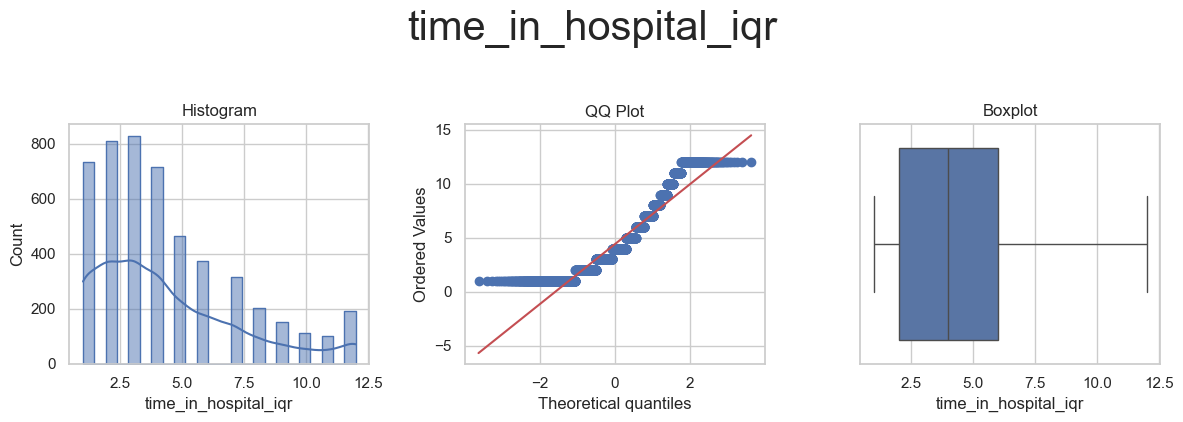

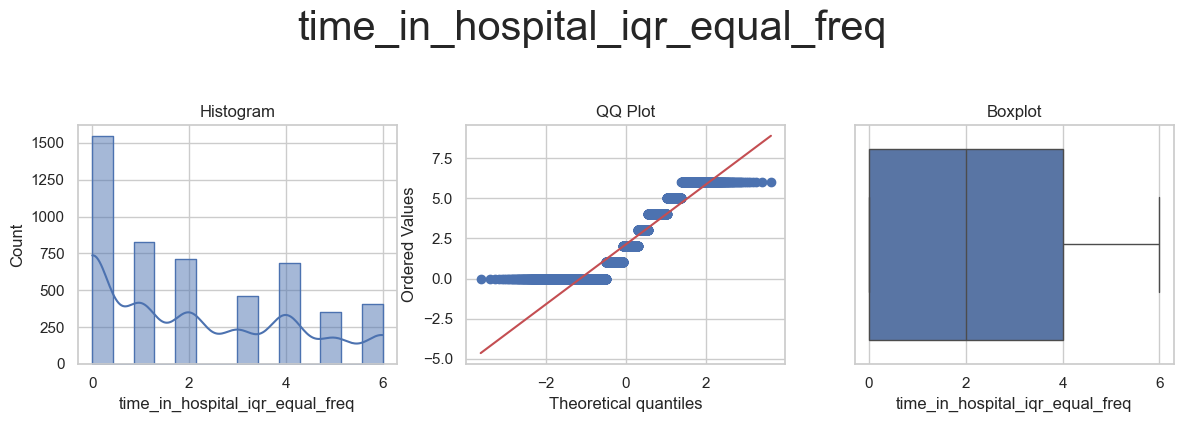

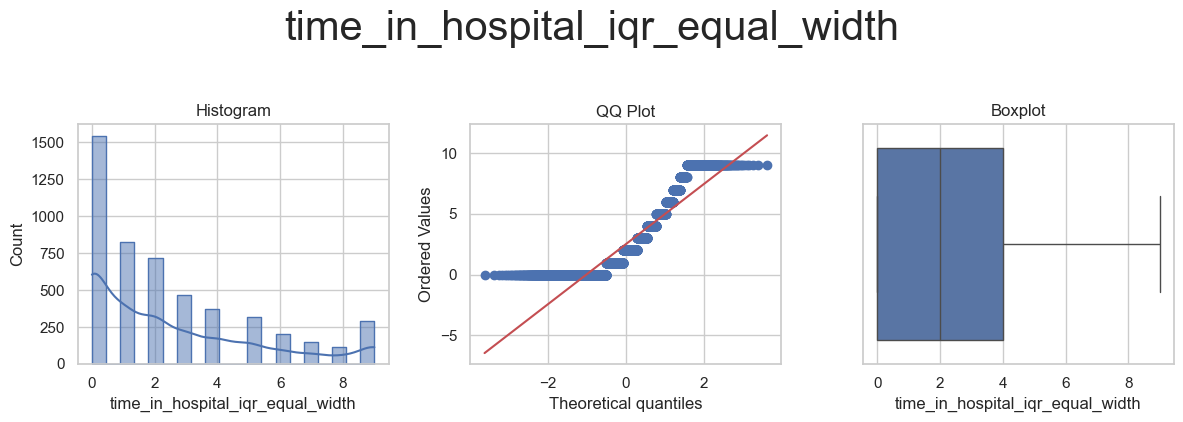

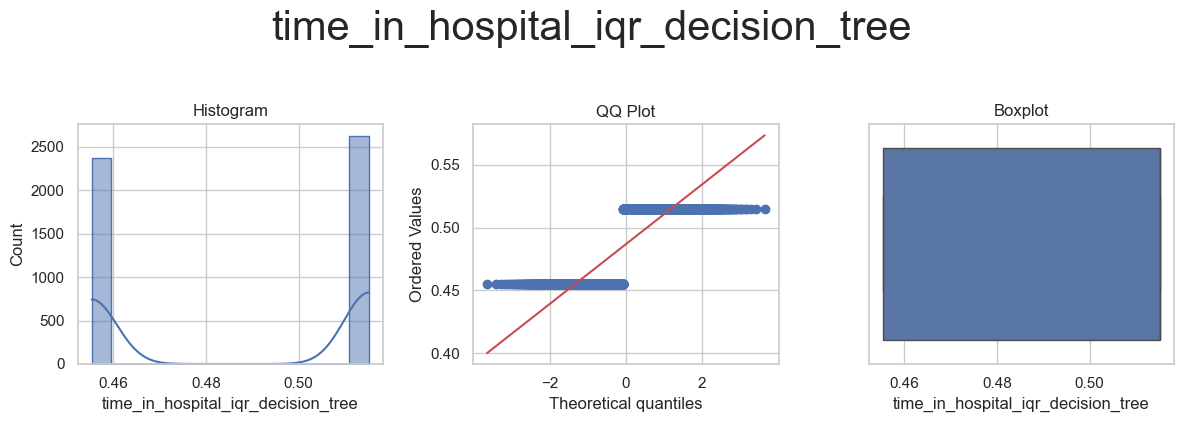



* Variable Analyzed: n_procedures_iqr
* Applied transformation: ['n_procedures_iqr_equal_freq', 'n_procedures_iqr_equal_width', 'n_procedures_iqr_decision_tree'] 



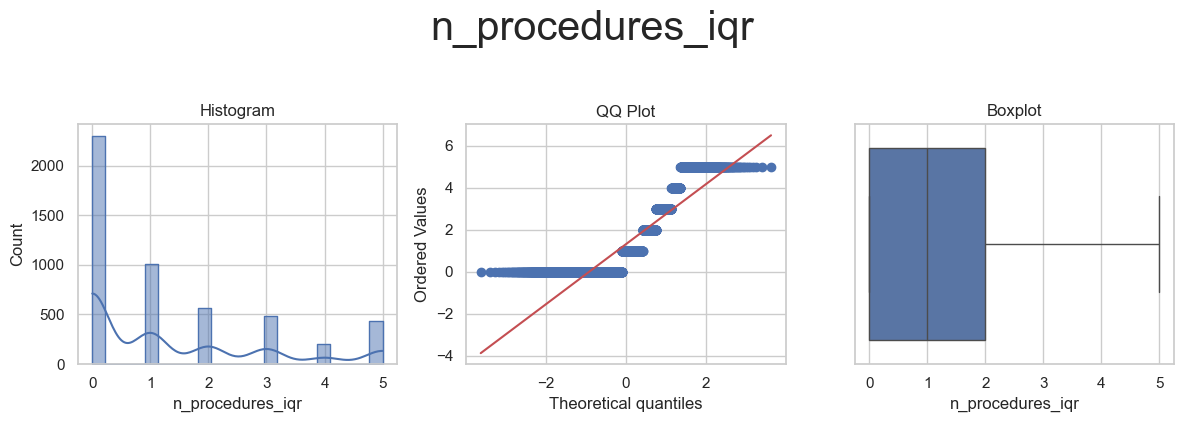

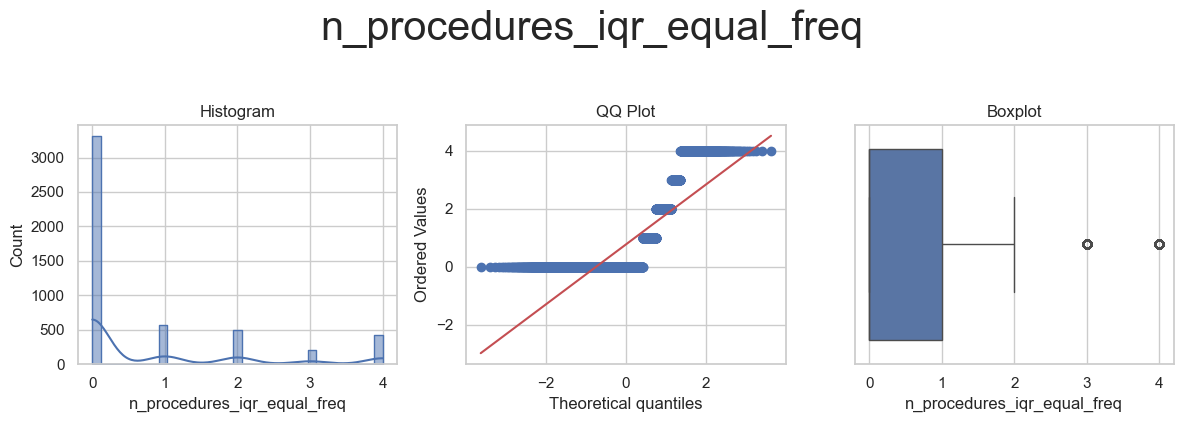

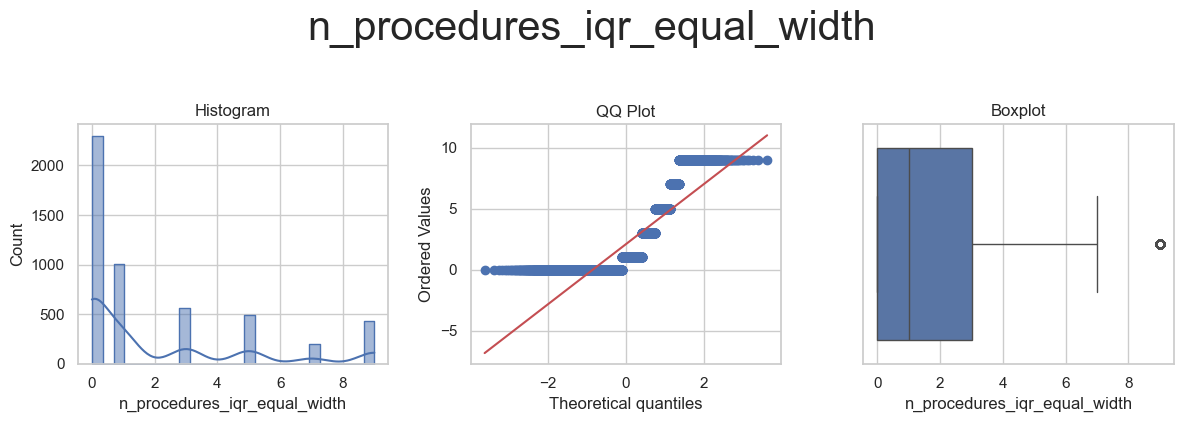

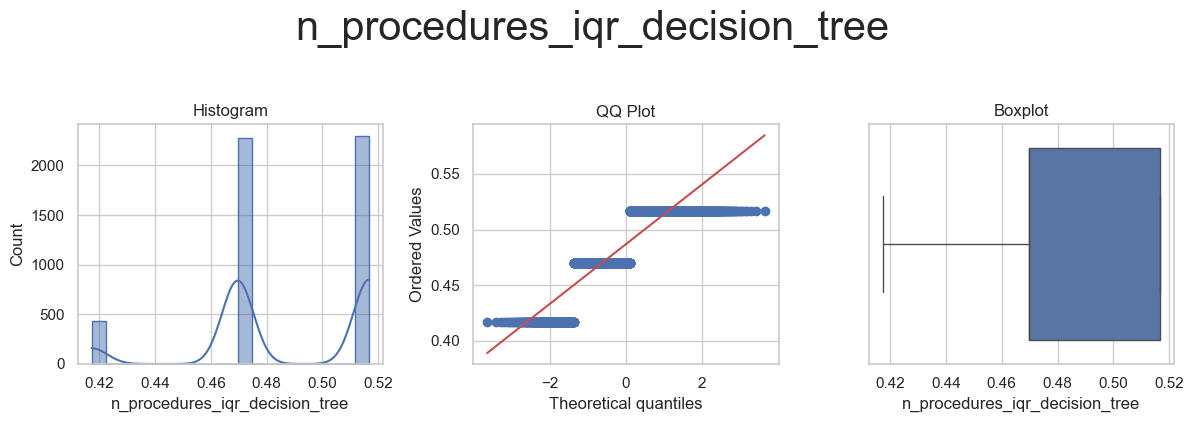



* Variable Analyzed: n_medications_iqr
* Applied transformation: ['n_medications_iqr_equal_freq', 'n_medications_iqr_equal_width', 'n_medications_iqr_decision_tree'] 



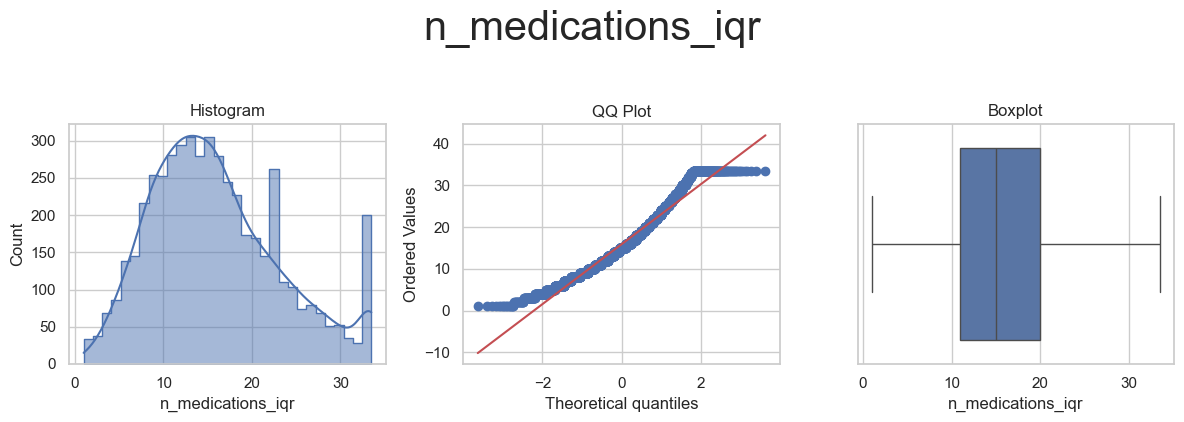

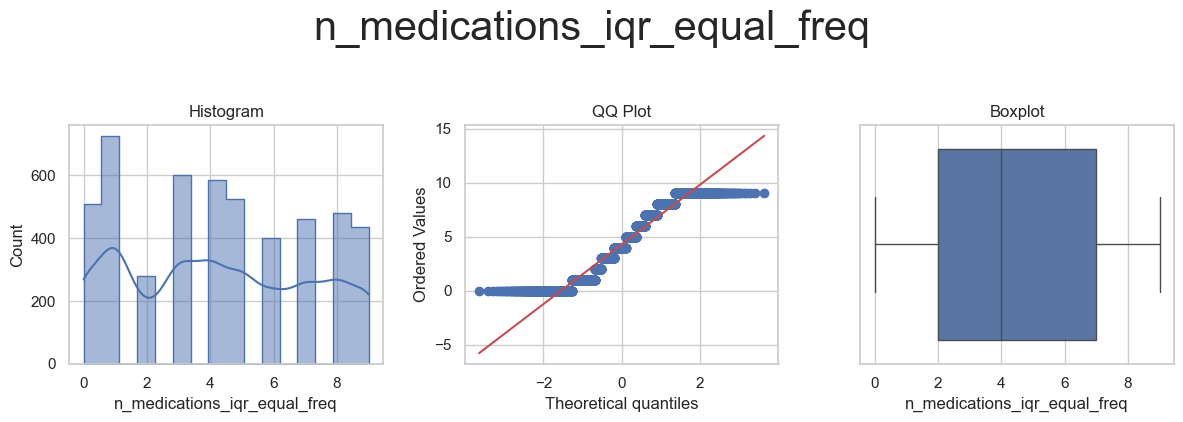

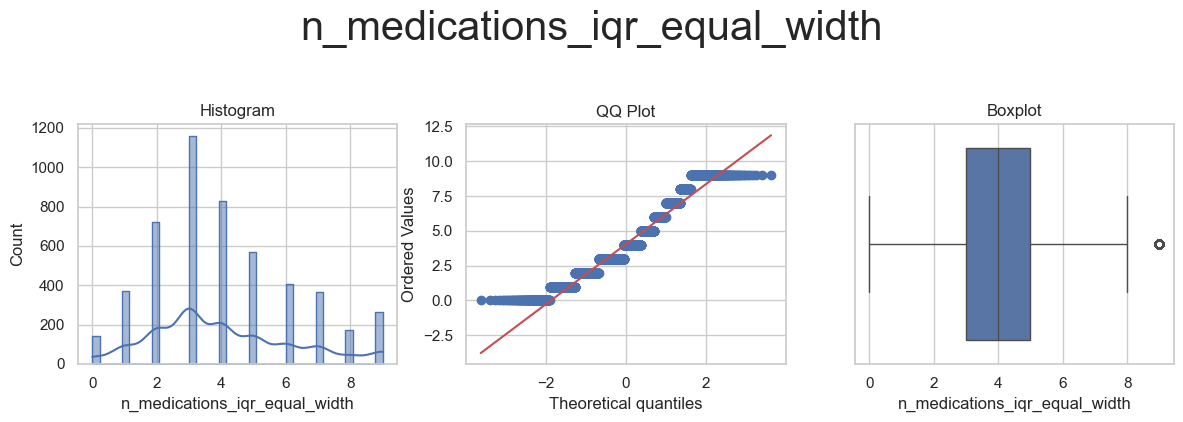

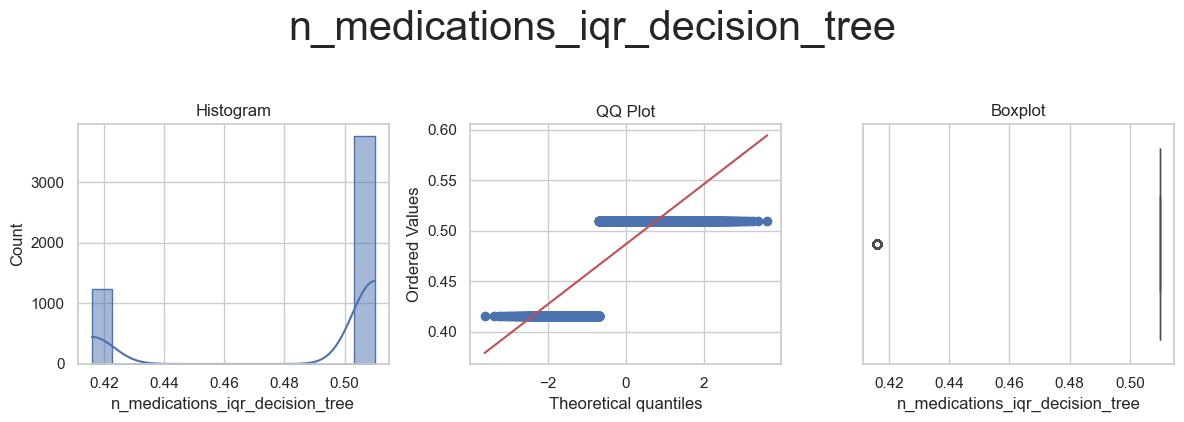



* Variable Analyzed: n_inpatient_iqr
* Applied transformation: ['n_inpatient_iqr_equal_freq', 'n_inpatient_iqr_equal_width', 'n_inpatient_iqr_decision_tree'] 



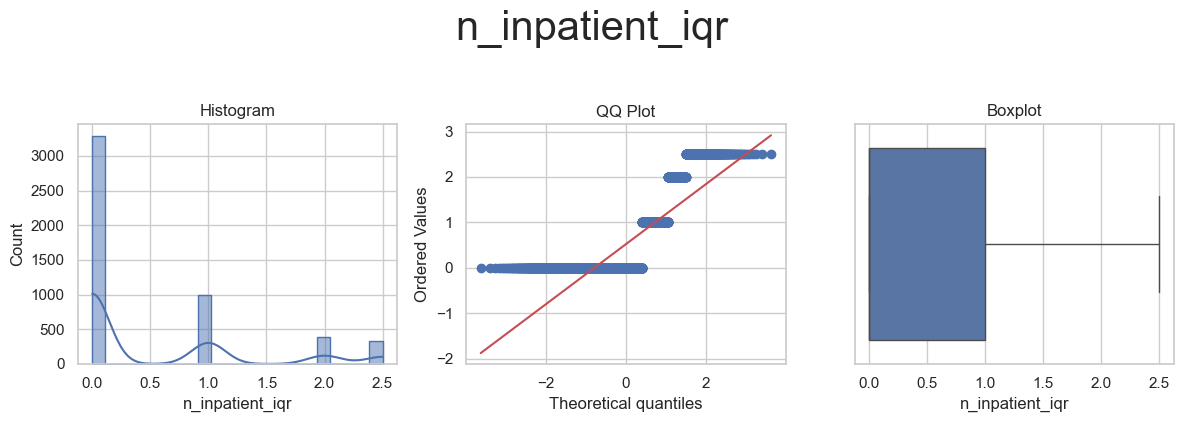

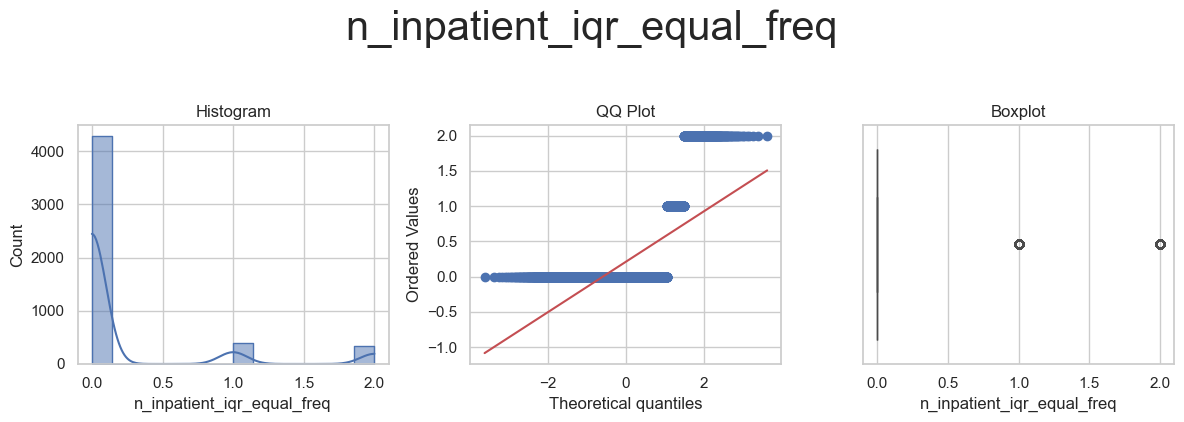

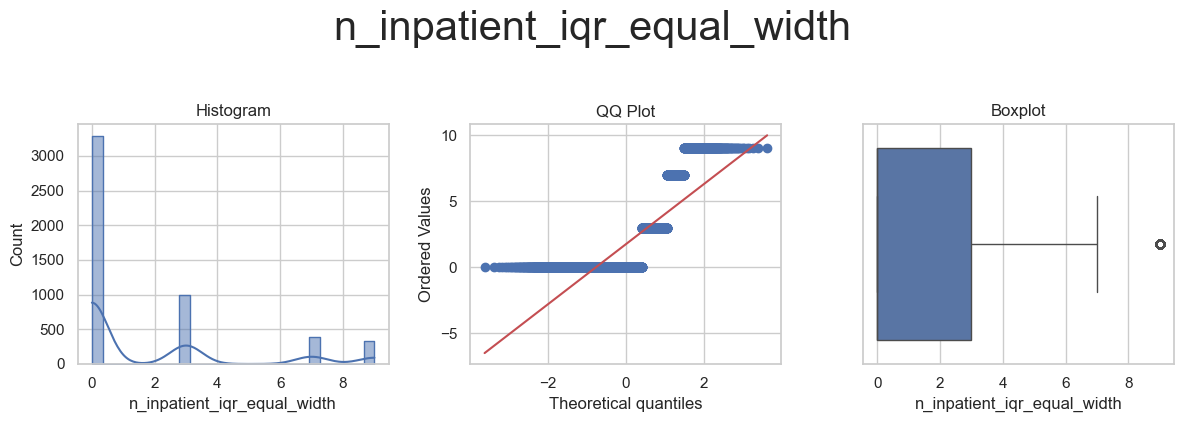

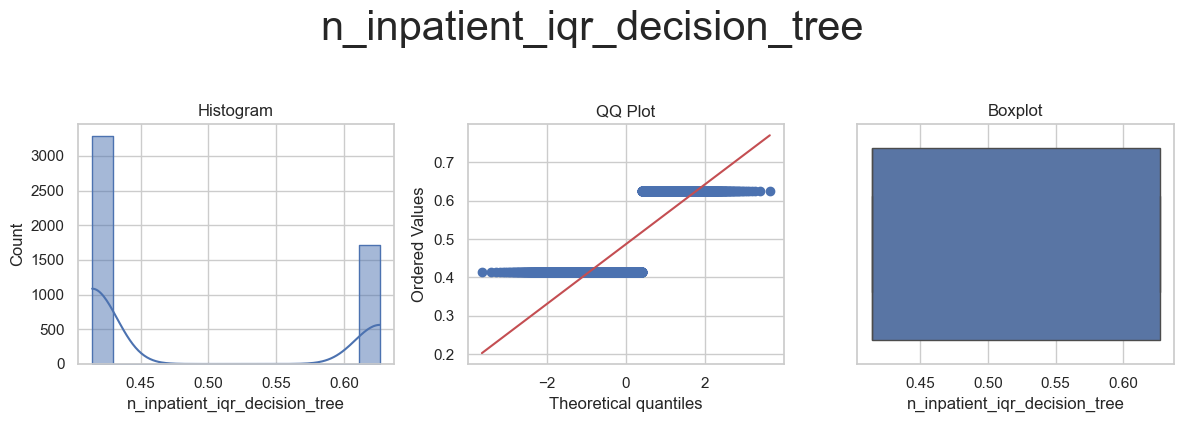



* Variable Analyzed: n_emergency_gaussian
* Applied transformation: ['n_emergency_gaussian_equal_freq', 'n_emergency_gaussian_equal_width', 'n_emergency_gaussian_decision_tree'] 



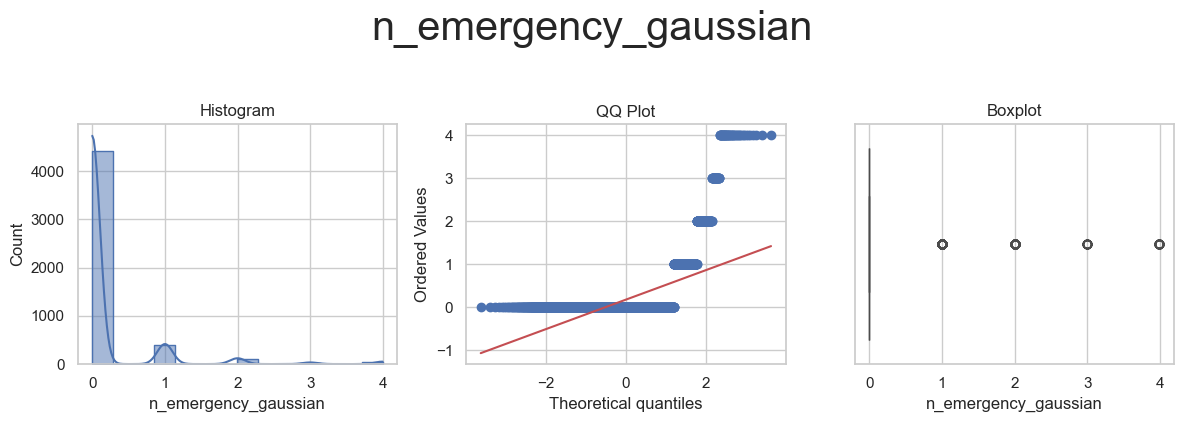

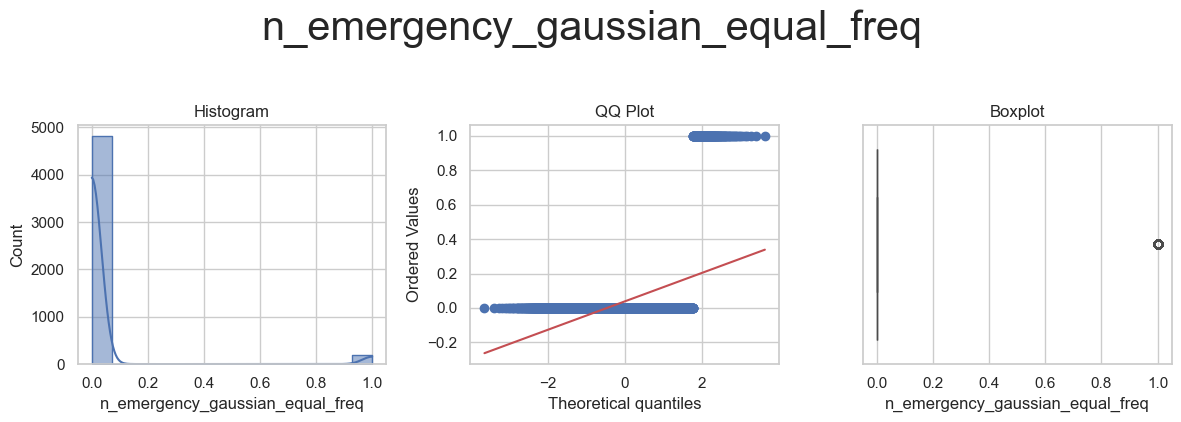

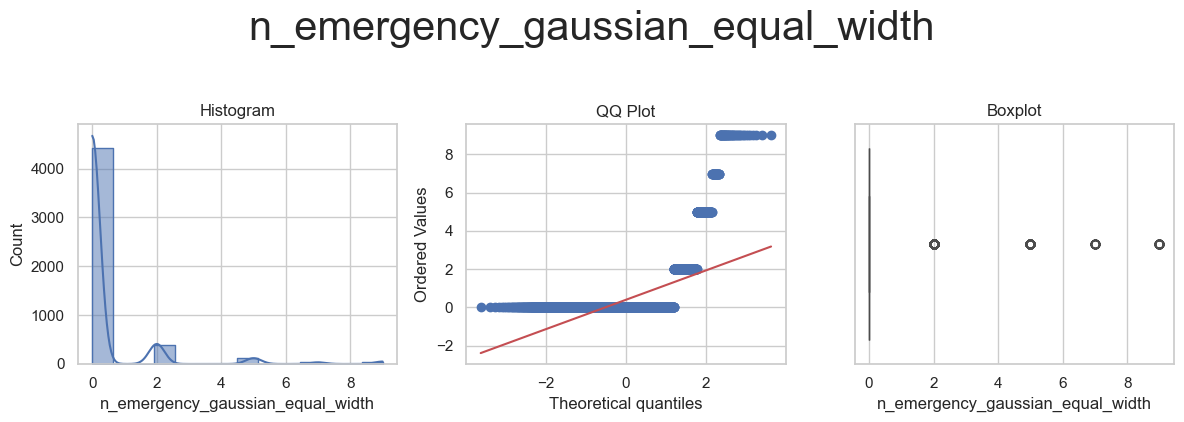

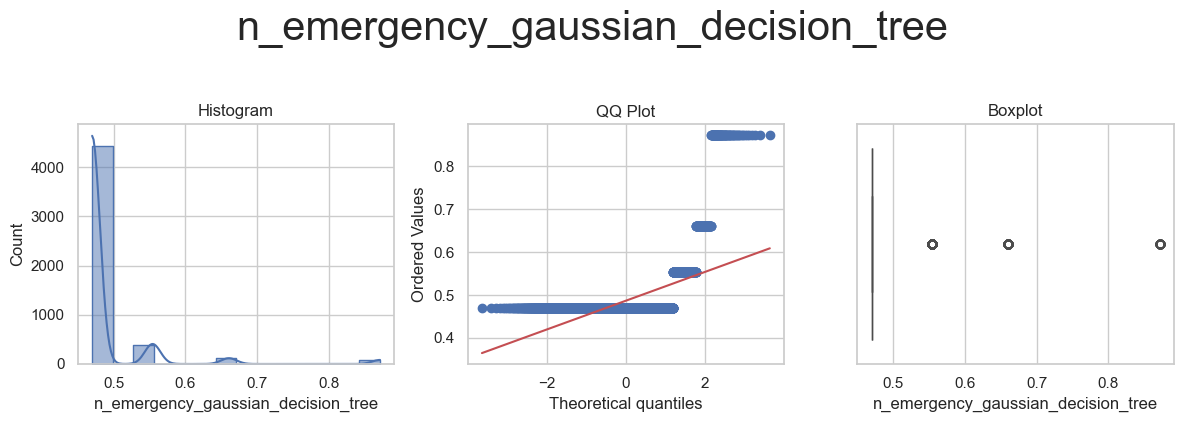



* Variable Analyzed: n_outpatient_gaussian
* Applied transformation: ['n_outpatient_gaussian_equal_freq', 'n_outpatient_gaussian_equal_width', 'n_outpatient_gaussian_decision_tree'] 



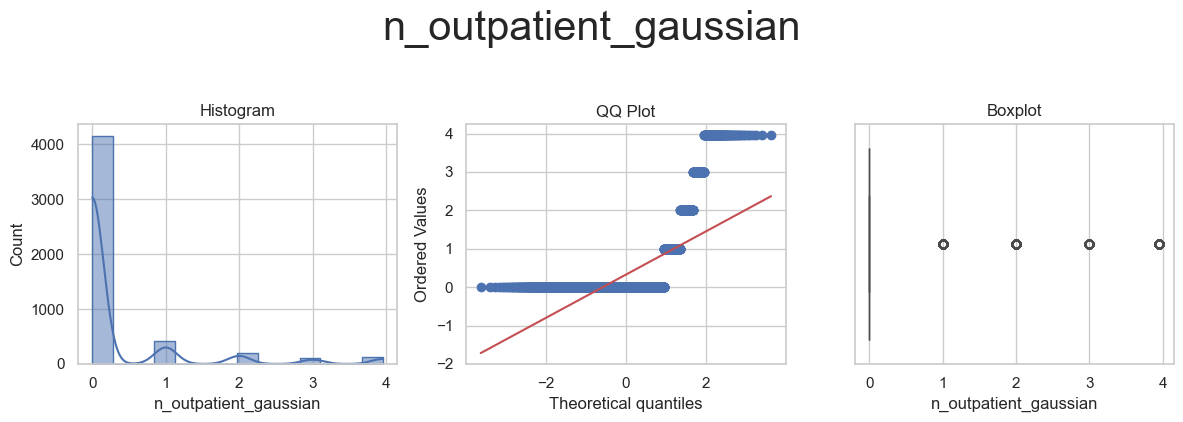

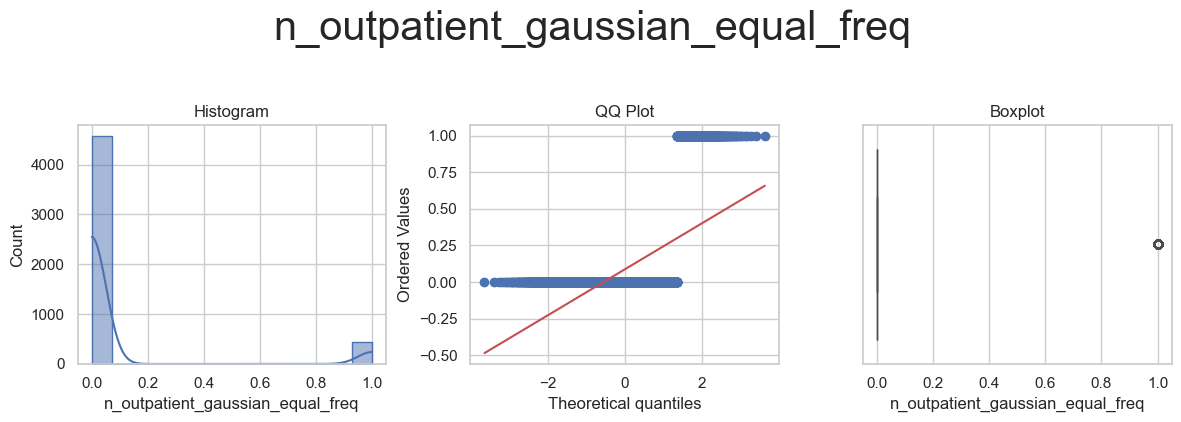

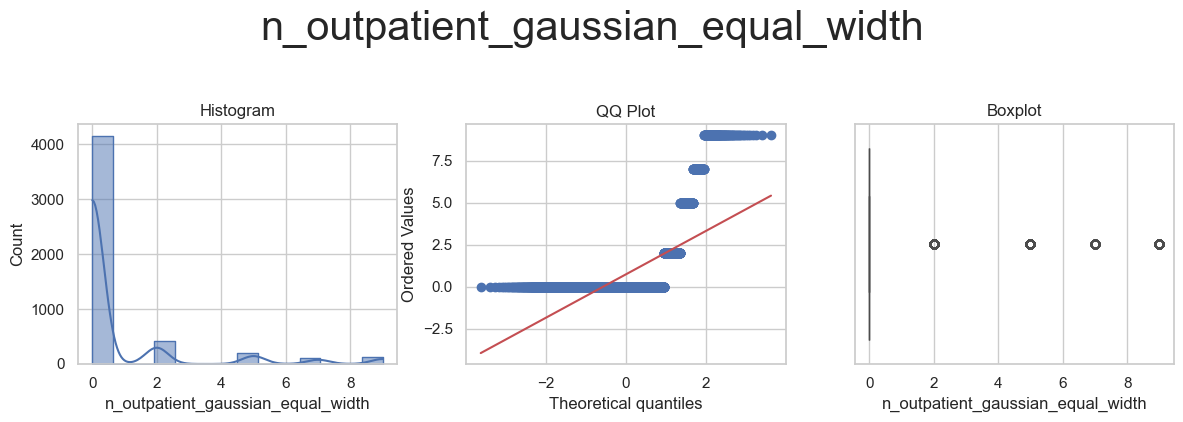

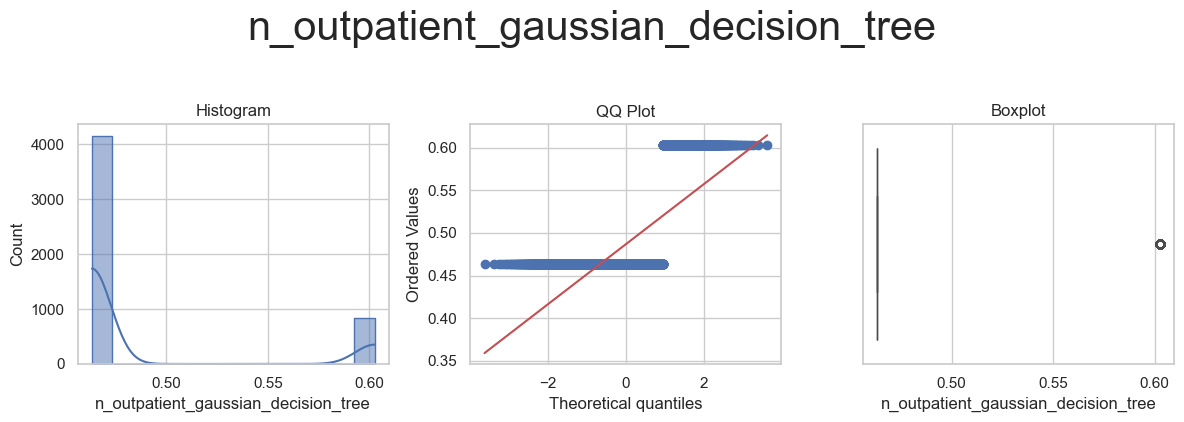



* Variable Analyzed: readmitted
* Applied transformation: ['readmitted_equal_freq', 'readmitted_equal_width', 'readmitted_decision_tree'] 



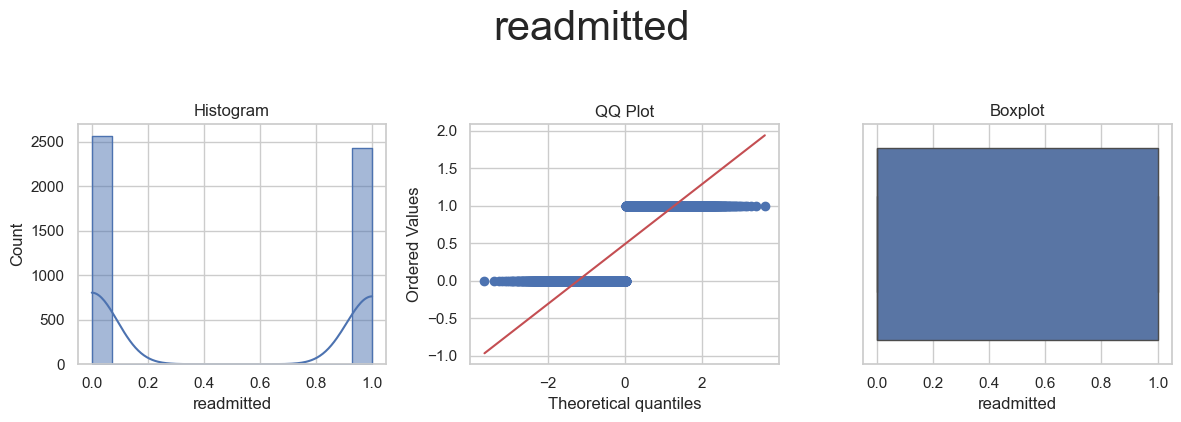

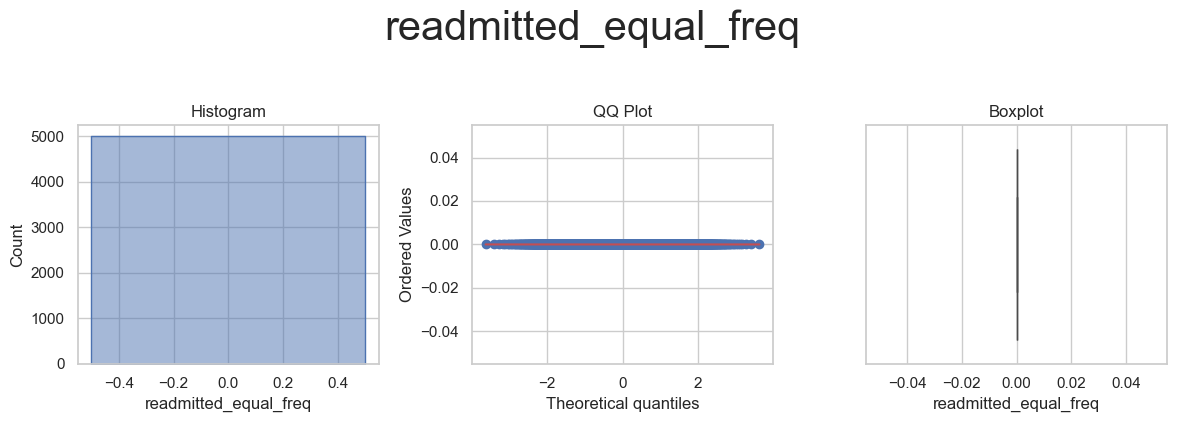

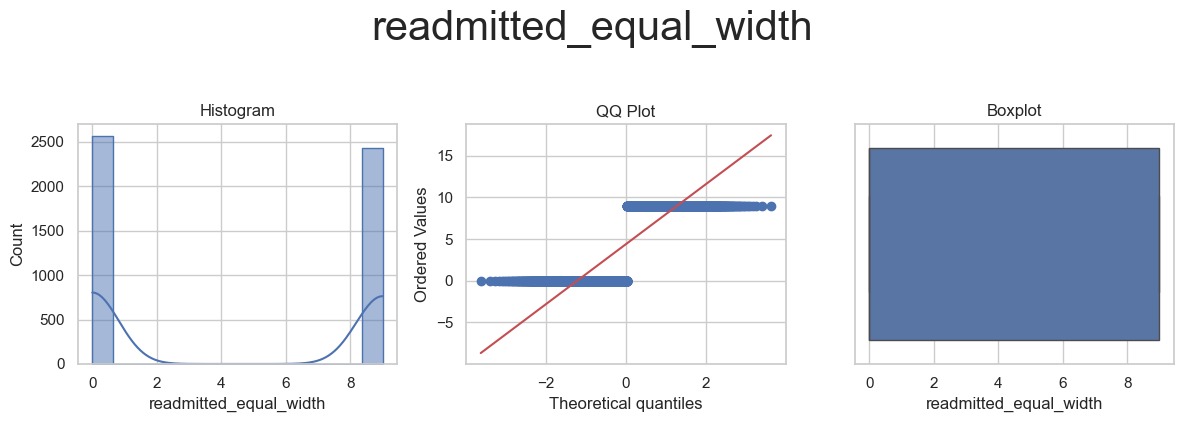

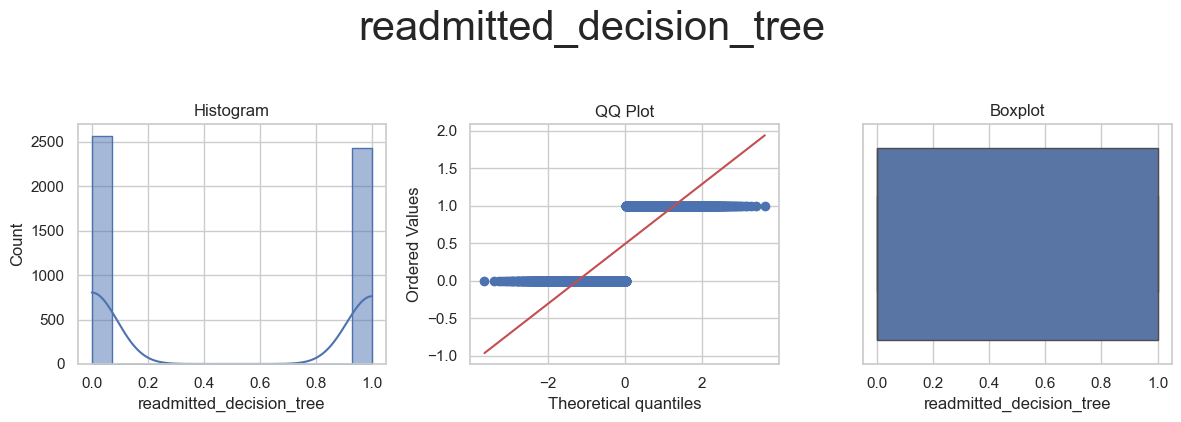

In [16]:
df_outliers_discr_eng = FeatureEngineeringAnalysis(df_num_discr, analysis_type='discretisation', y=df_num_discr['readmitted'])

In [17]:
df_num = df_outliers_after_eng.copy()
df_num.head()

time_in_hospital_iqr  n_procedures_iqr  n_medications_iqr  n_inpatient_iqr  \
0                     1                 1                5.0              2.5   
1                     1                 1               12.0              0.0   
2                     4                 3               15.0              0.0   
3                     3                 0               13.0              2.5   
4                     5                 0               11.0              1.0   

   n_emergency_gaussian  n_outpatient_gaussian  
0                   2.0                    0.0  
1                   0.0                    0.0  
2                   0.0                    1.0  
3                   0.0                    0.0  
4                   0.0                    0.0

* Variable Analyzed: time_in_hospital_iqr
* Applied transformation: ['time_in_hospital_iqr_log_e', 'time_in_hospital_iqr_log_10', 'time_in_hospital_iqr_reciprocal', 'time_in_hospital_iqr_power', 'time_in_hospital_iqr_box_cox', 'time_in_hospital_iqr_yeo_johnson'] 



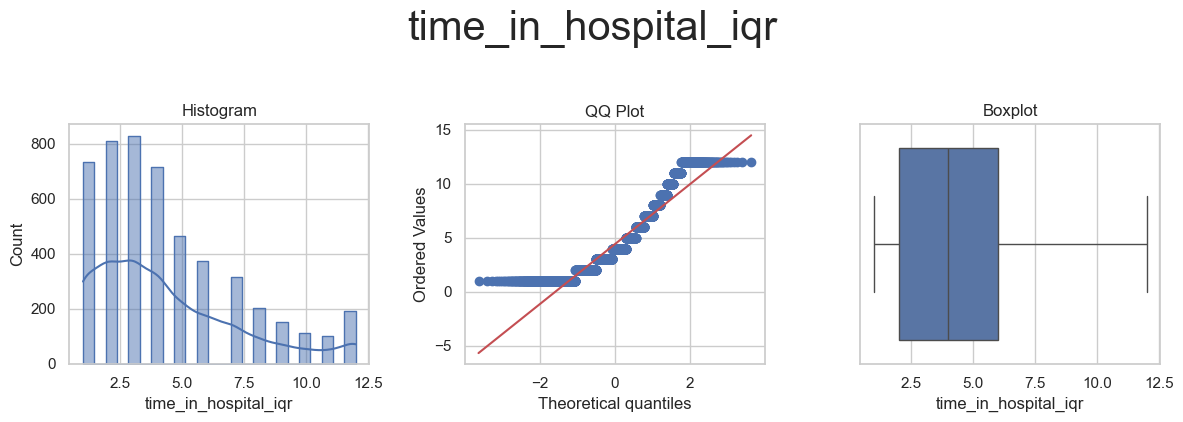

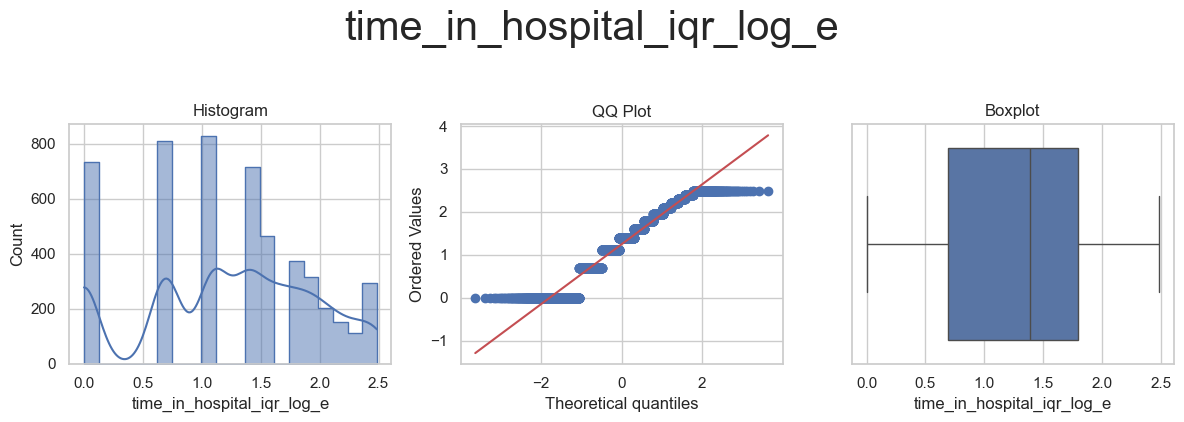

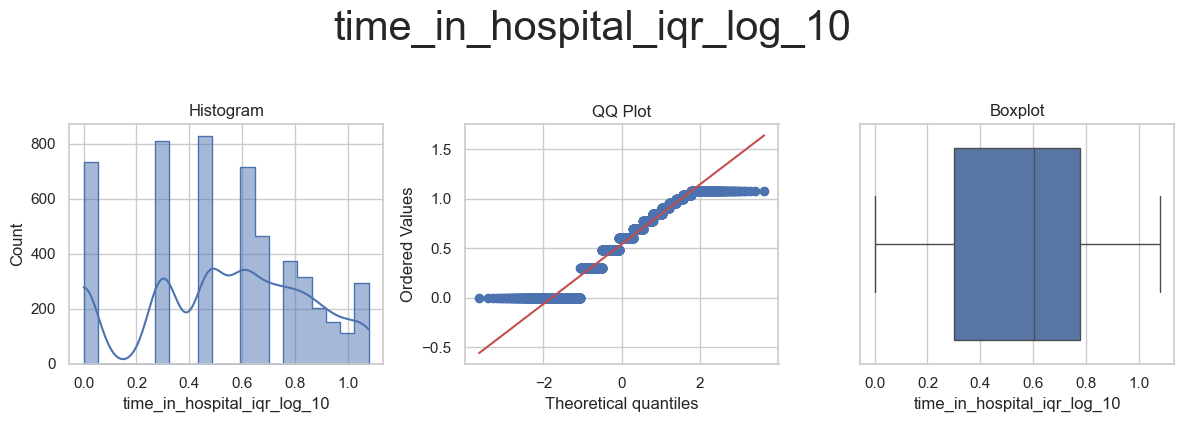

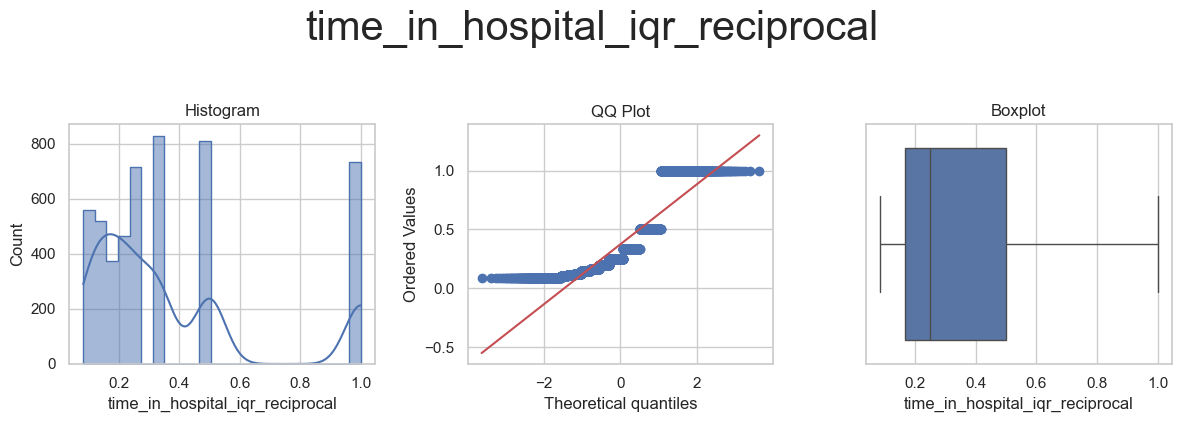

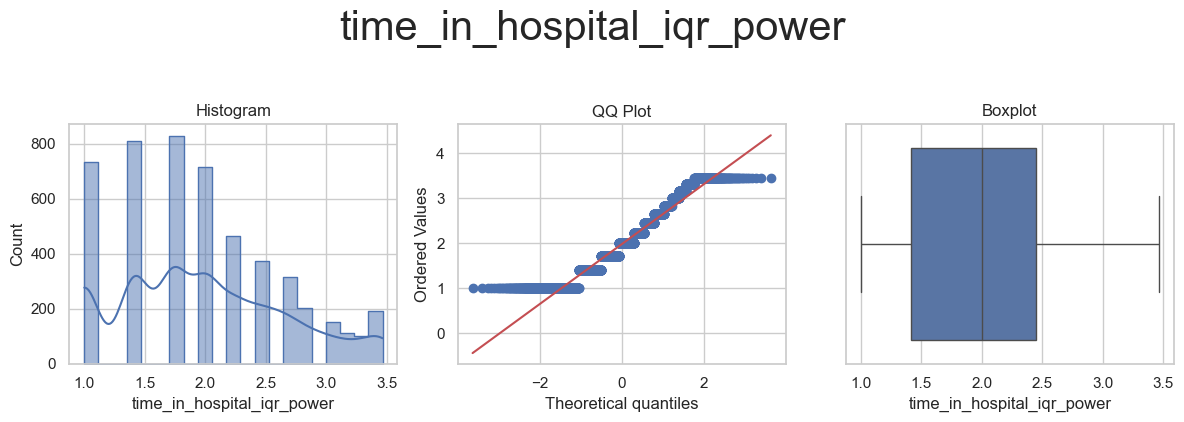

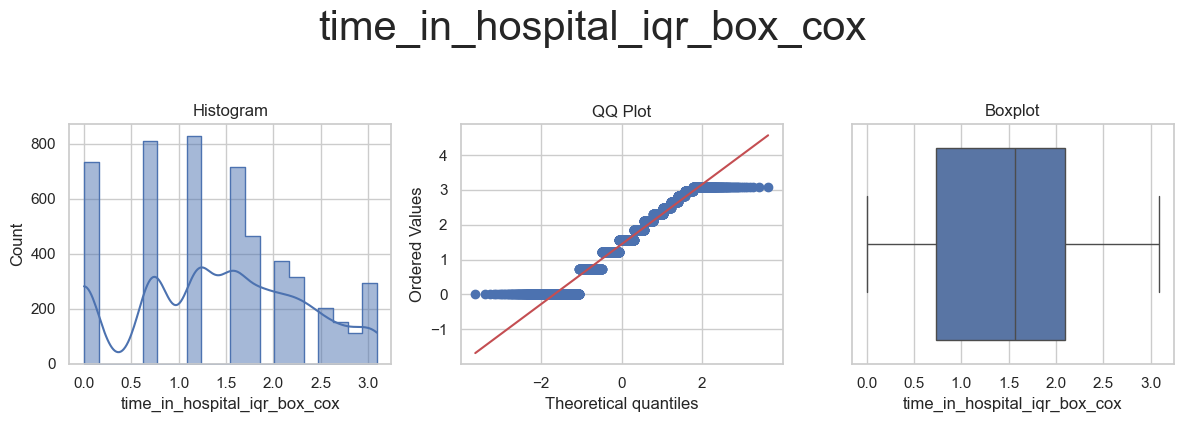

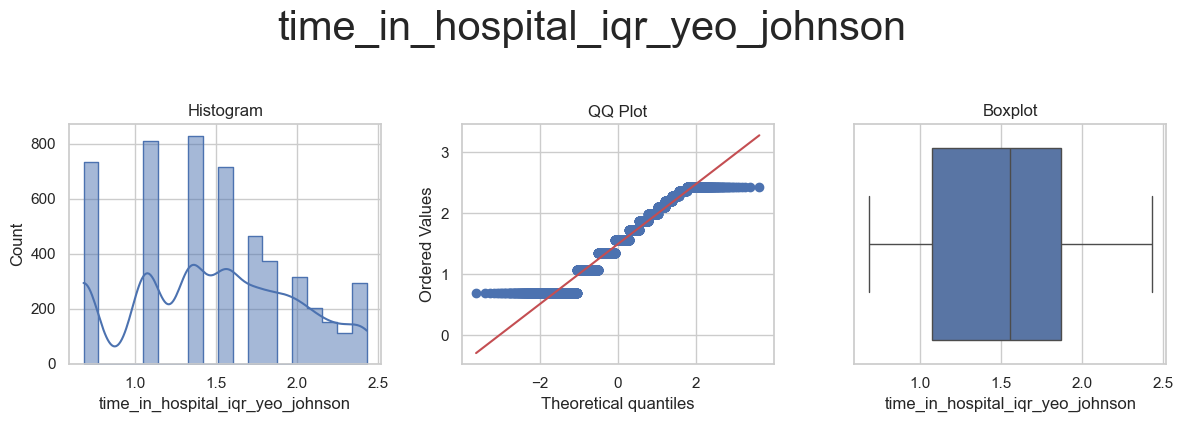



LogTransformer failed for n_procedures_iqr: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_procedures_iqr: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_procedures_iqr: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_procedures_iqr: Data must be positive.
* Variable Analyzed: n_procedures_iqr
* Applied transformation: ['n_procedures_iqr_power', 'n_procedures_iqr_yeo_johnson'] 



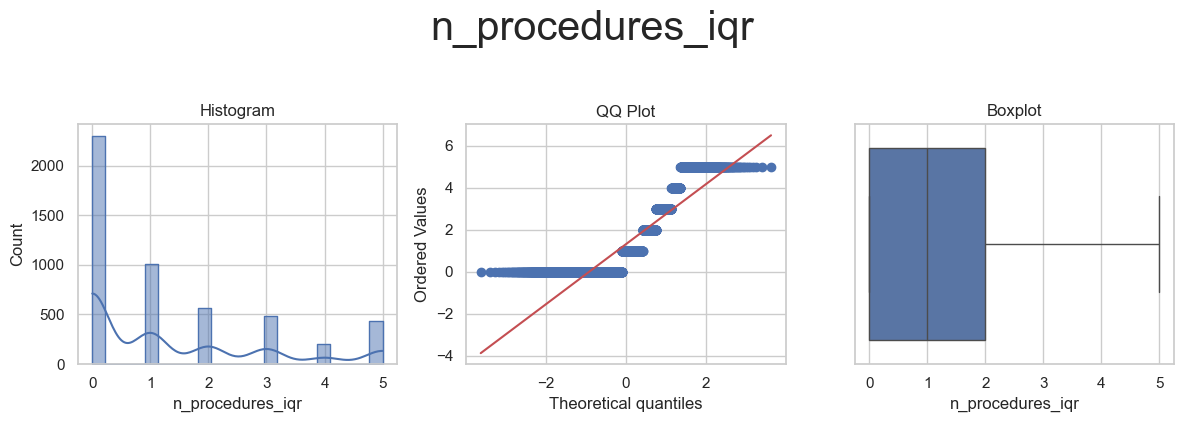

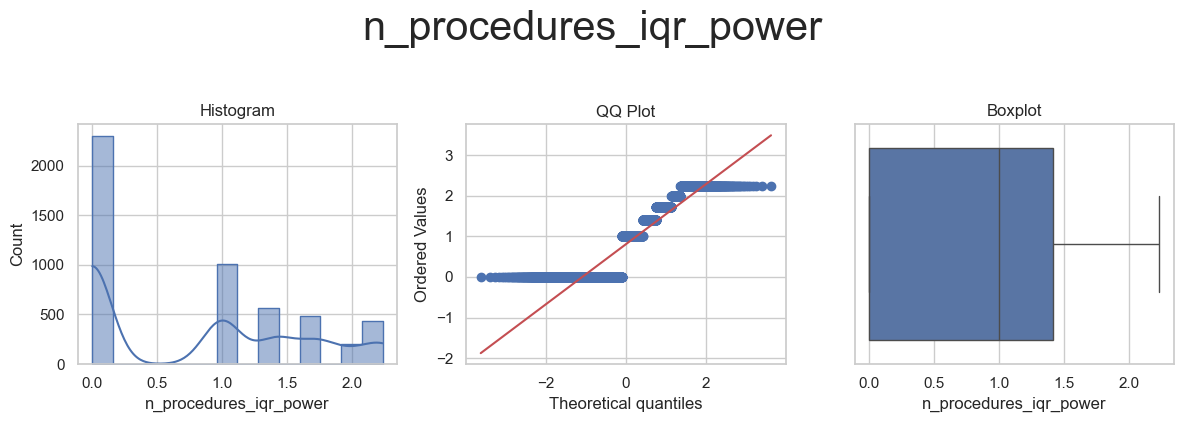

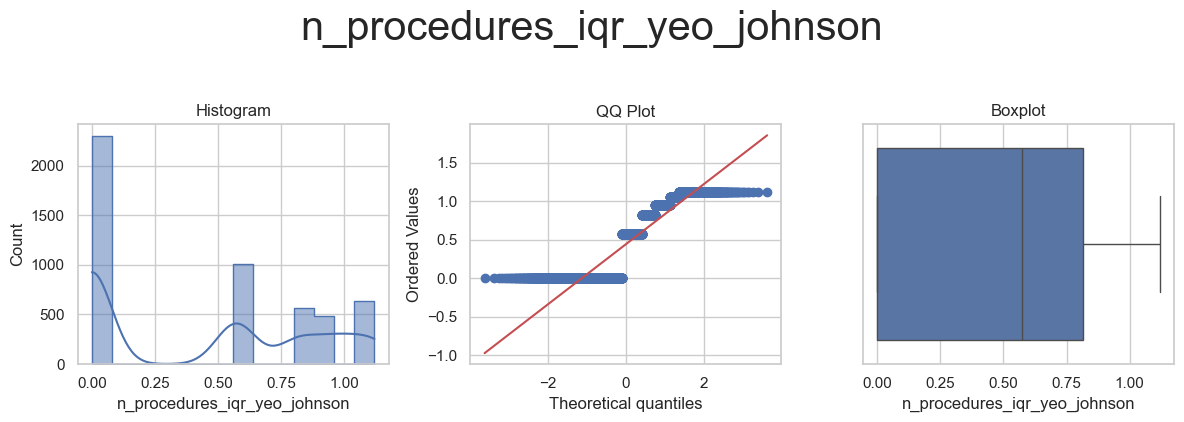



* Variable Analyzed: n_medications_iqr
* Applied transformation: ['n_medications_iqr_log_e', 'n_medications_iqr_log_10', 'n_medications_iqr_reciprocal', 'n_medications_iqr_power', 'n_medications_iqr_box_cox', 'n_medications_iqr_yeo_johnson'] 



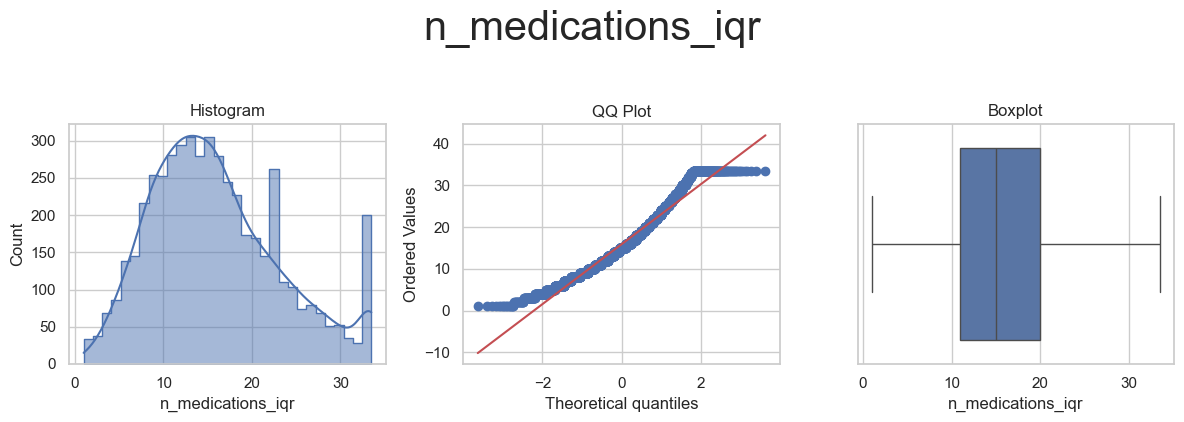

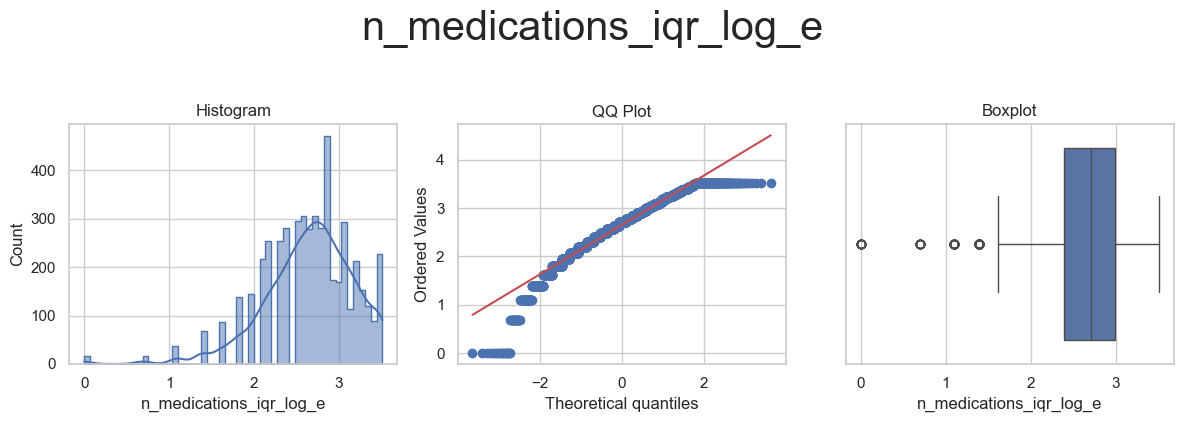

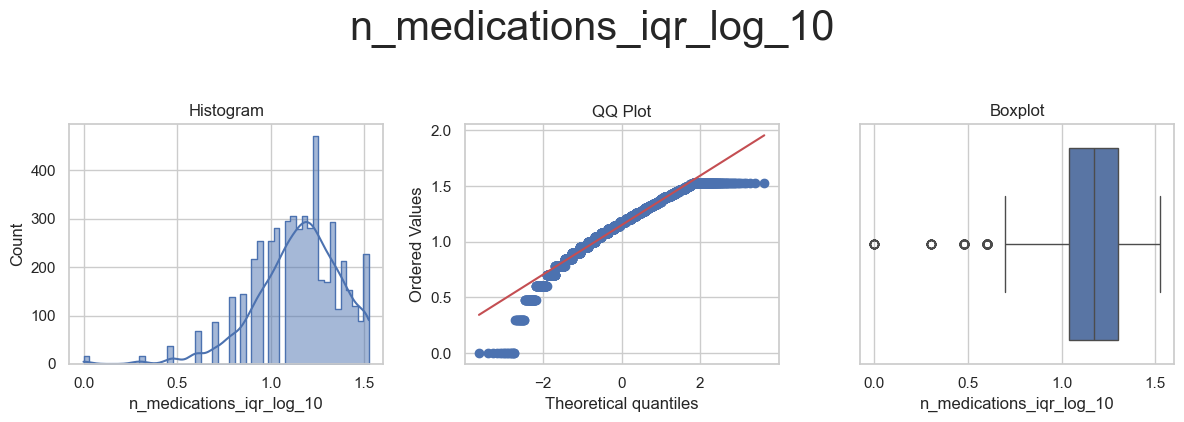

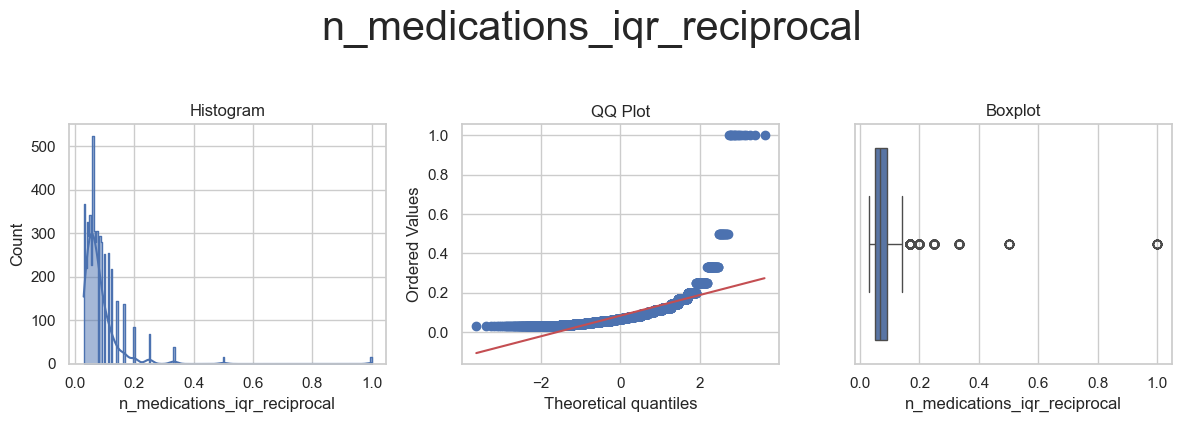

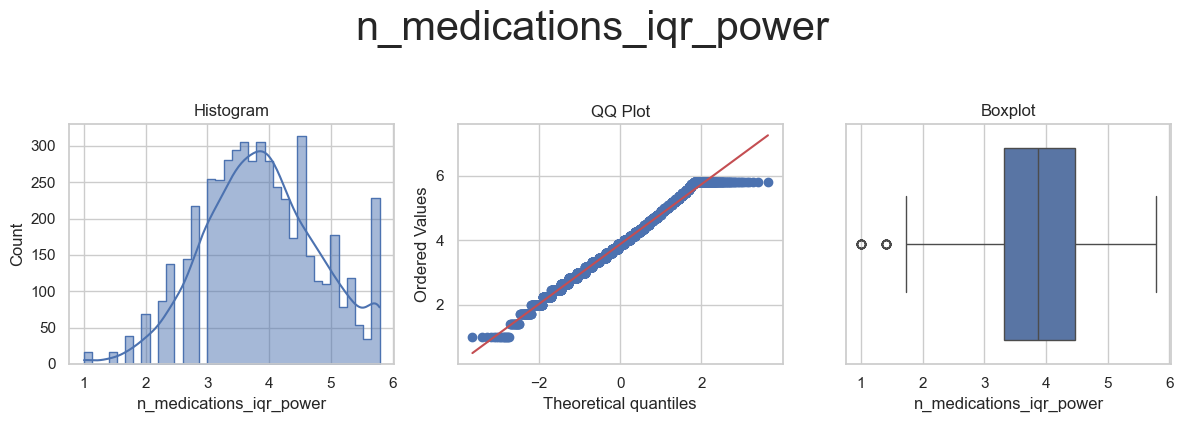

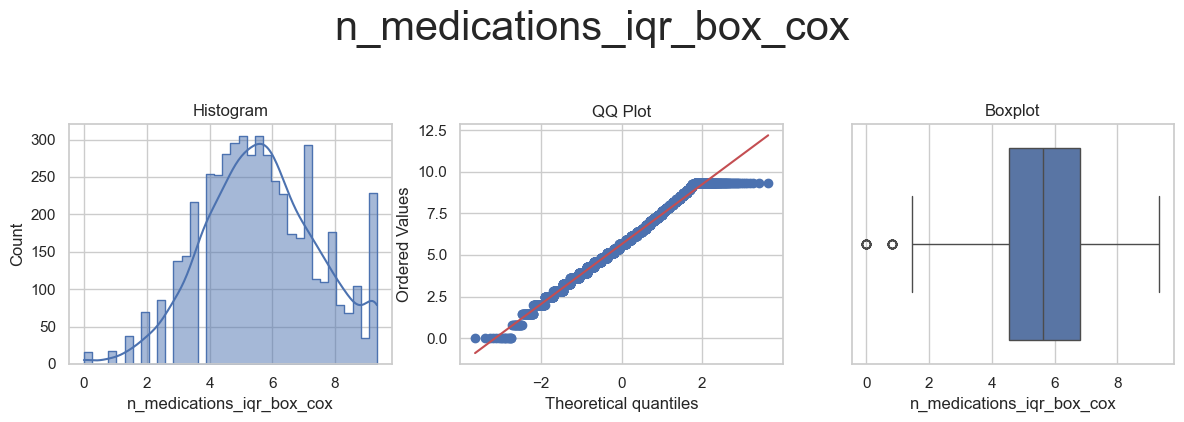

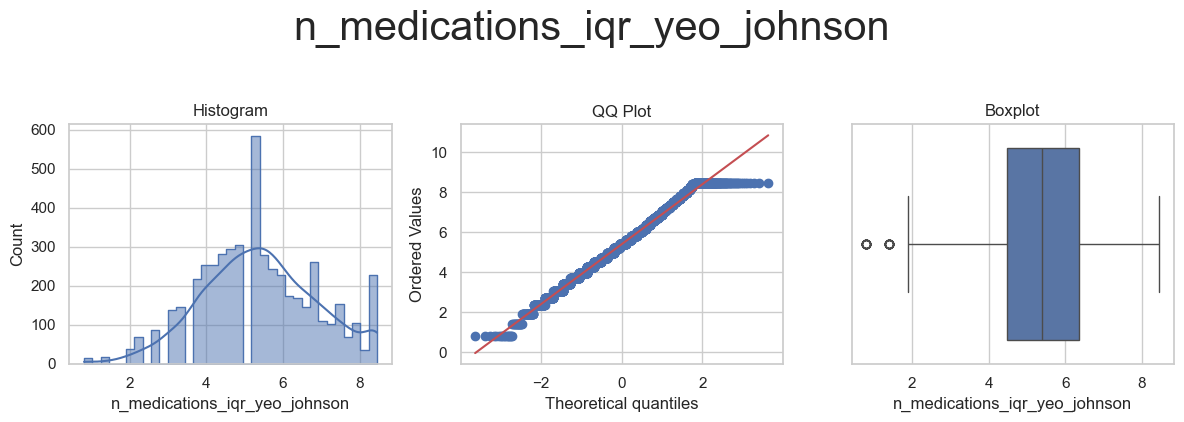



LogTransformer failed for n_inpatient_iqr: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_inpatient_iqr: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_inpatient_iqr: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_inpatient_iqr: Data must be positive.
* Variable Analyzed: n_inpatient_iqr
* Applied transformation: ['n_inpatient_iqr_power', 'n_inpatient_iqr_yeo_johnson'] 



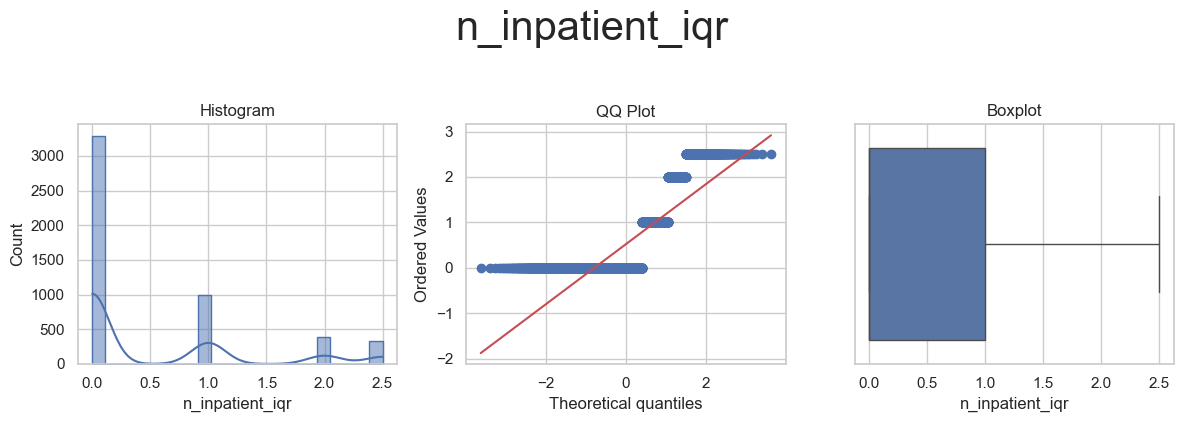

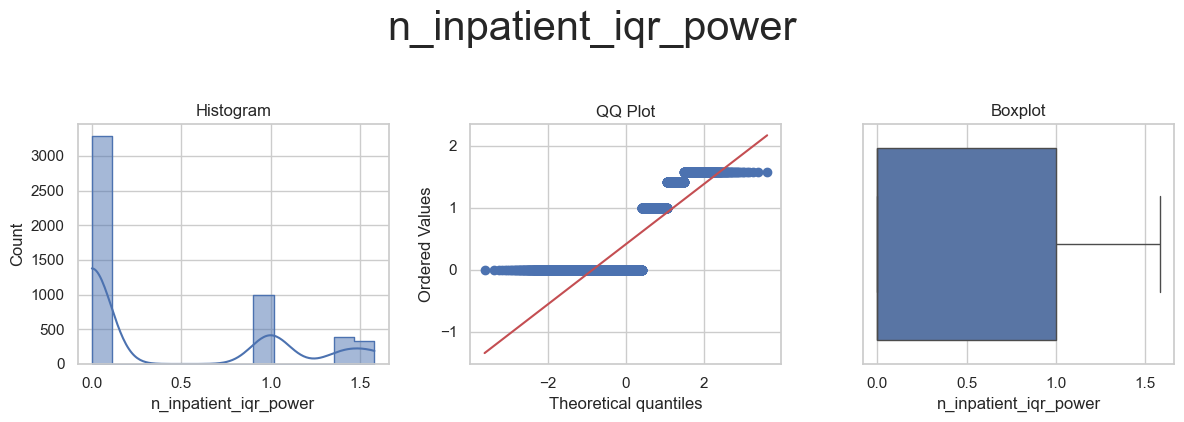

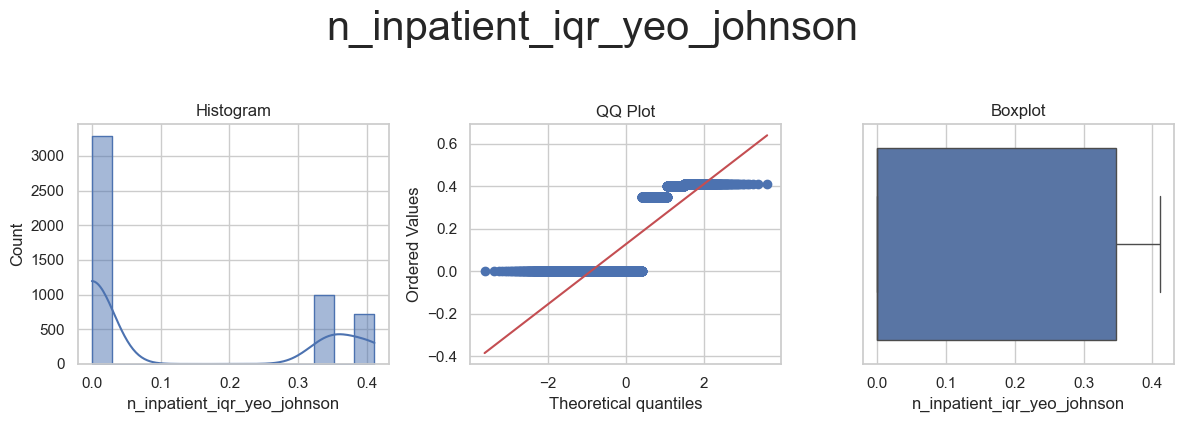



LogTransformer failed for n_emergency_gaussian: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_emergency_gaussian: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_emergency_gaussian: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_emergency_gaussian: Data must be positive.
* Variable Analyzed: n_emergency_gaussian
* Applied transformation: ['n_emergency_gaussian_power', 'n_emergency_gaussian_yeo_johnson'] 



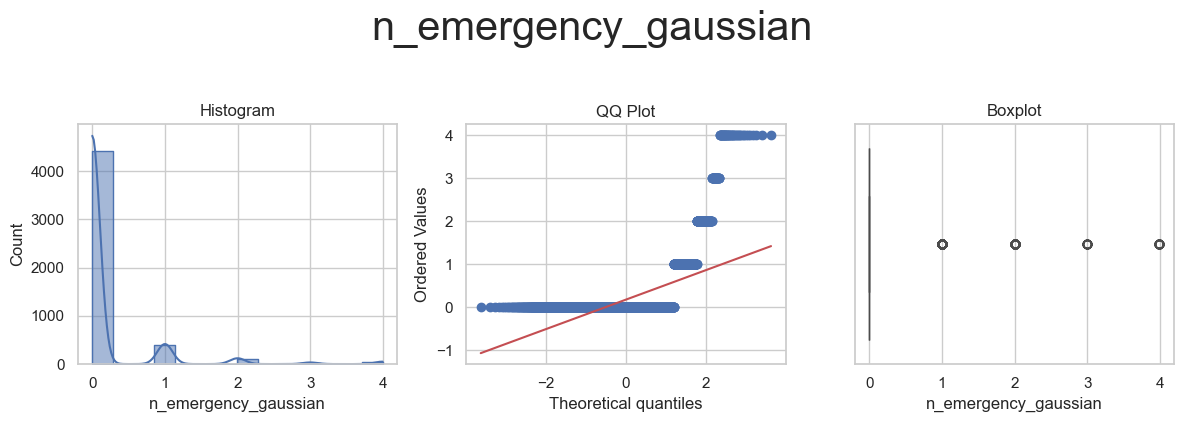

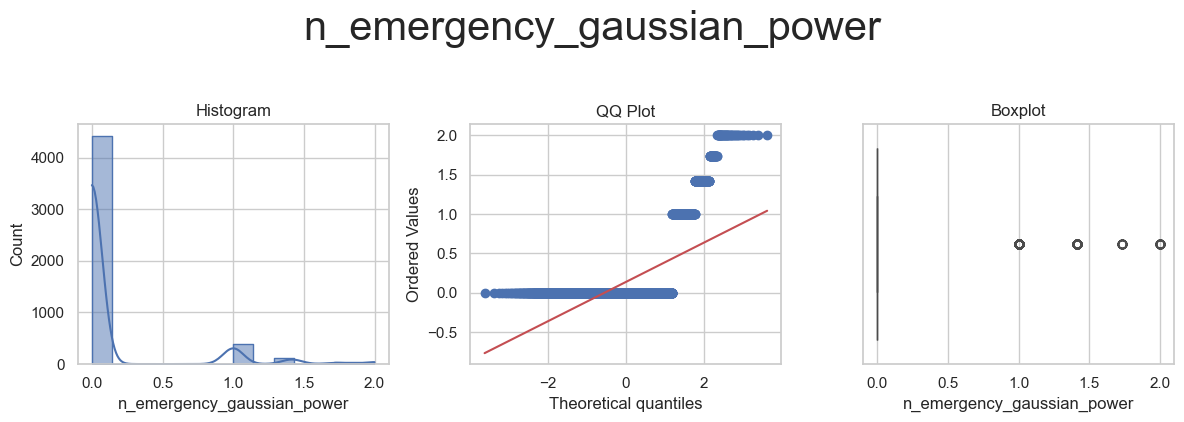

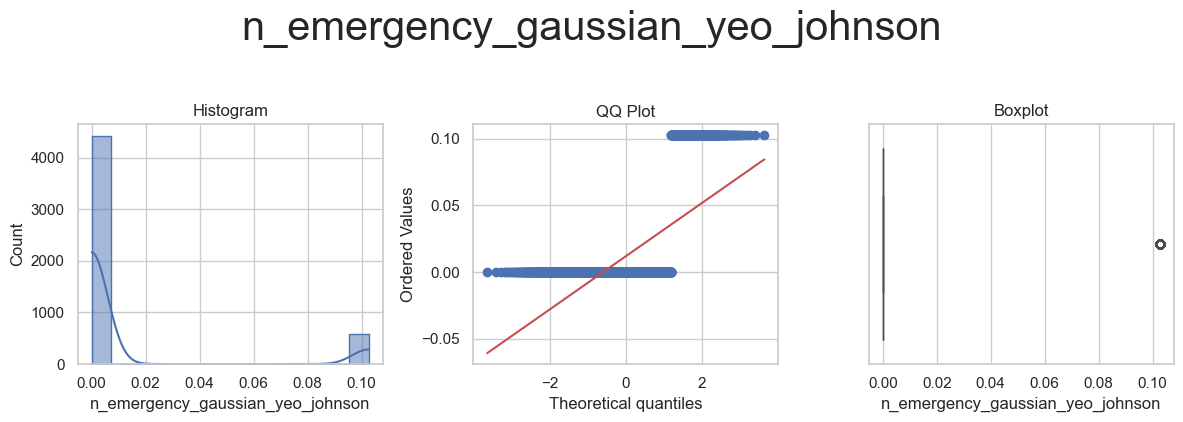



LogTransformer failed for n_outpatient_gaussian: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_outpatient_gaussian: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_outpatient_gaussian: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_outpatient_gaussian: Data must be positive.
* Variable Analyzed: n_outpatient_gaussian
* Applied transformation: ['n_outpatient_gaussian_power', 'n_outpatient_gaussian_yeo_johnson'] 



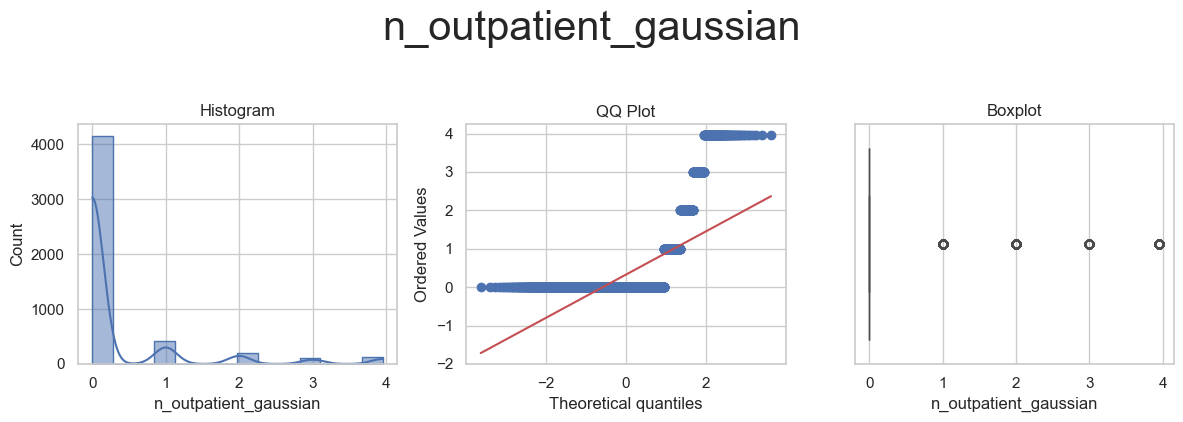

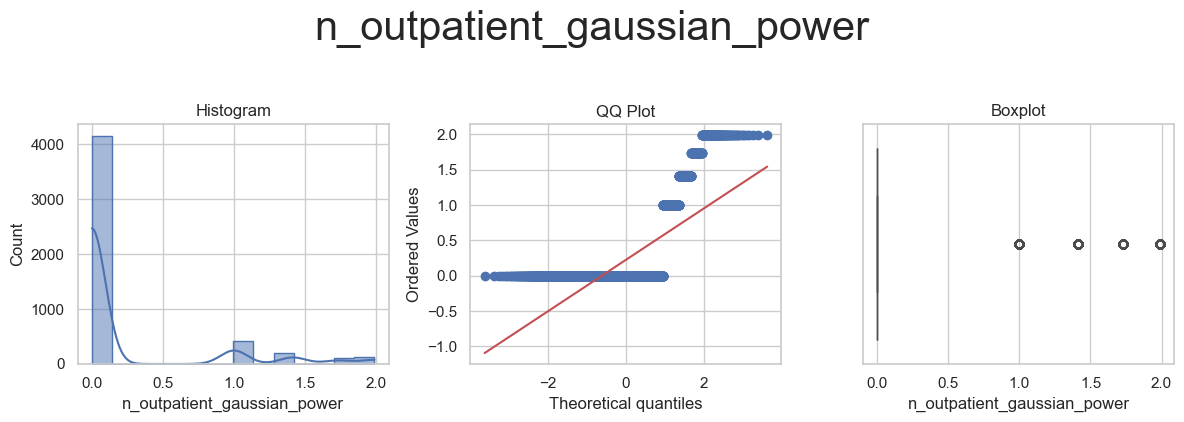

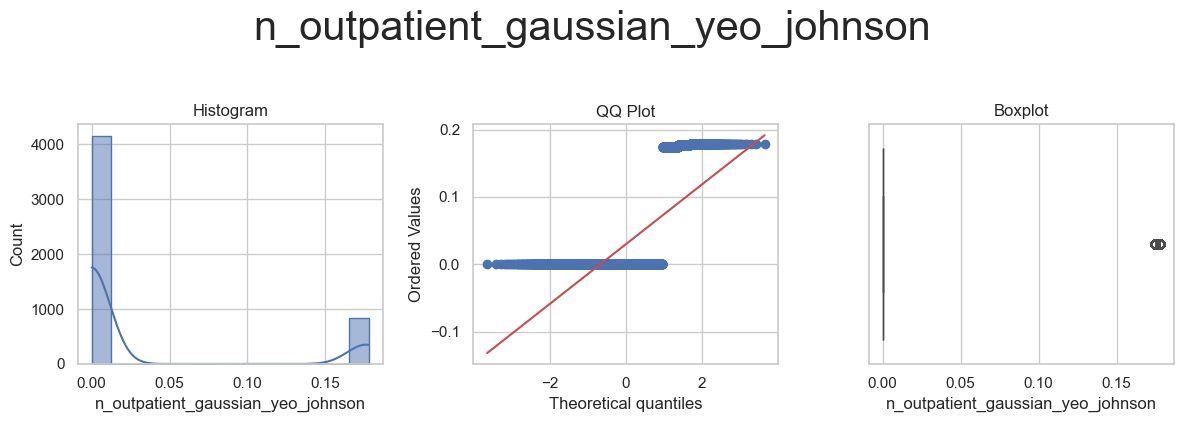

In [18]:
df_outliers_num_eng = FeatureEngineeringAnalysis(df_num, analysis_type='numerical')

* Variable Analyzed: time_in_hospital
* Applied transformation: ['time_in_hospital_log_e', 'time_in_hospital_log_10', 'time_in_hospital_reciprocal', 'time_in_hospital_power', 'time_in_hospital_box_cox', 'time_in_hospital_yeo_johnson'] 



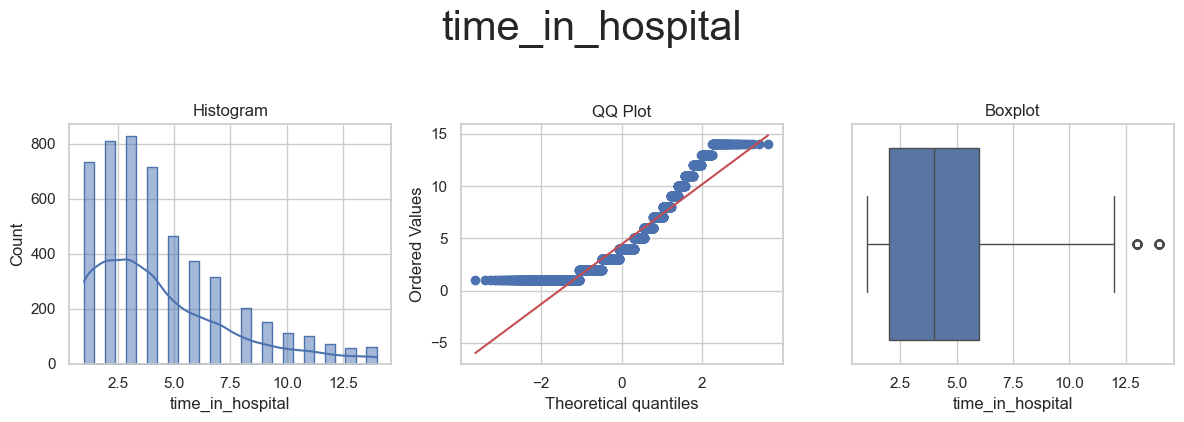

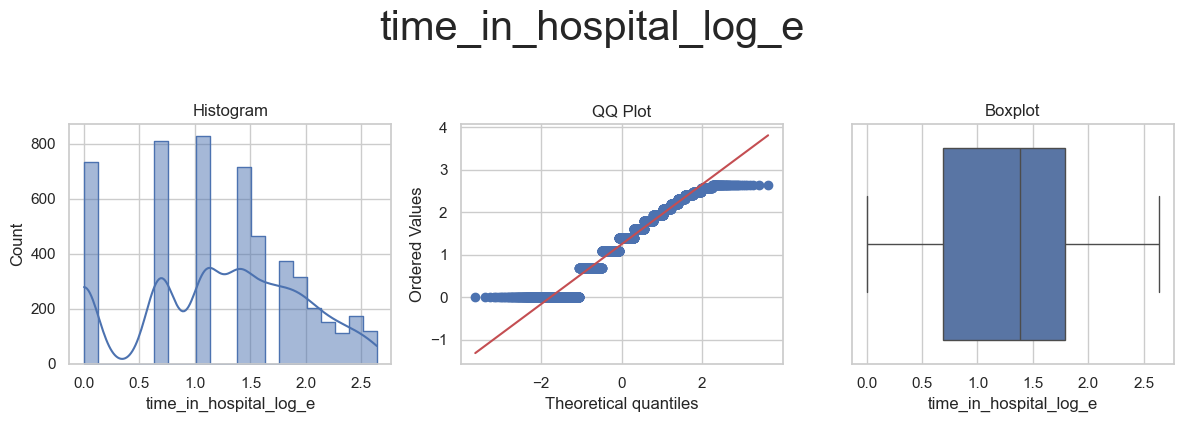

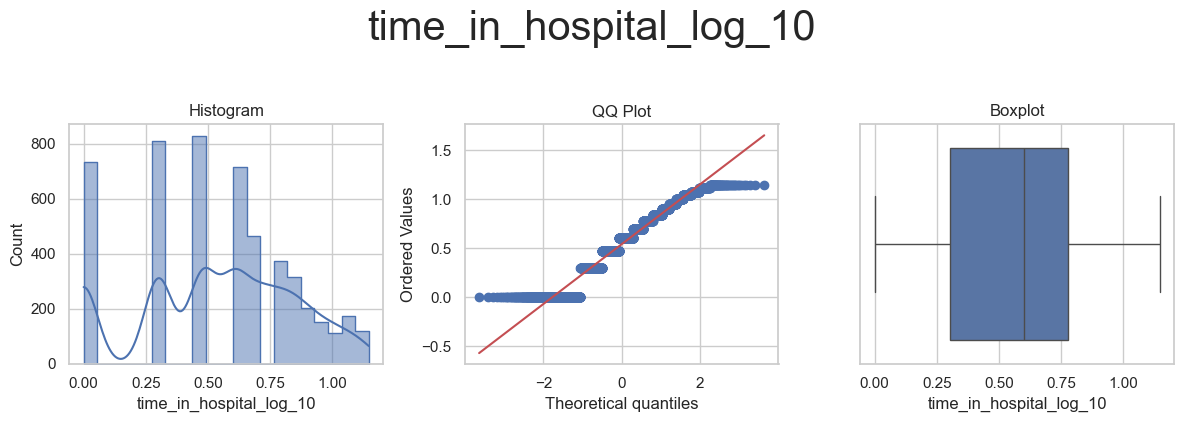

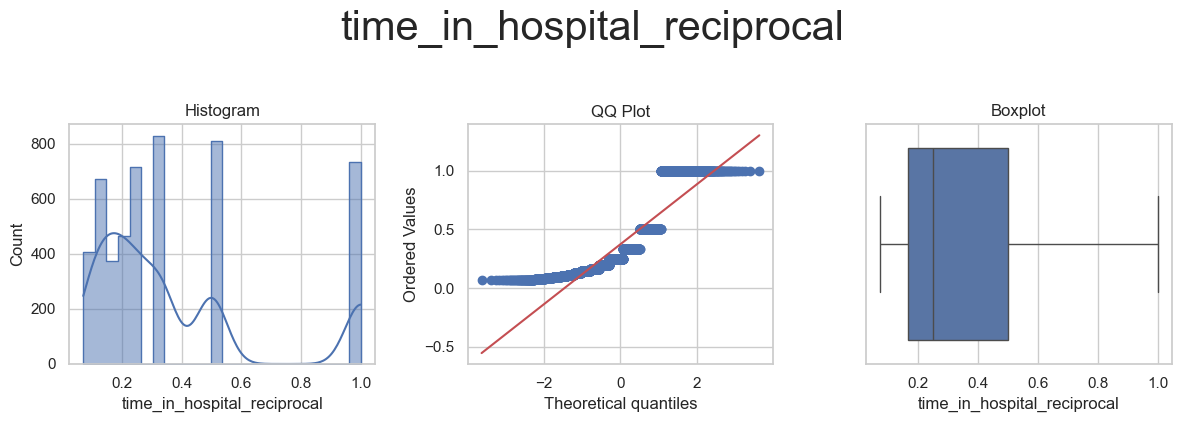

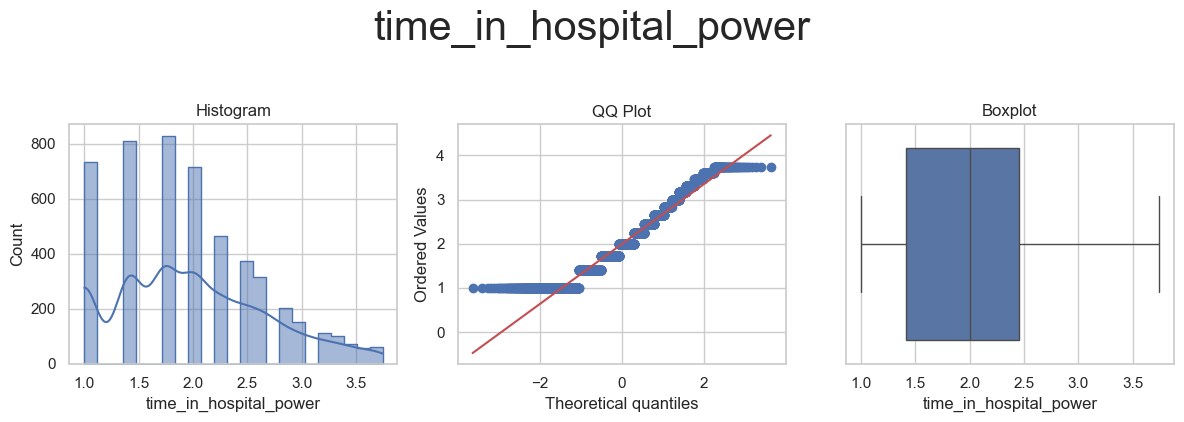

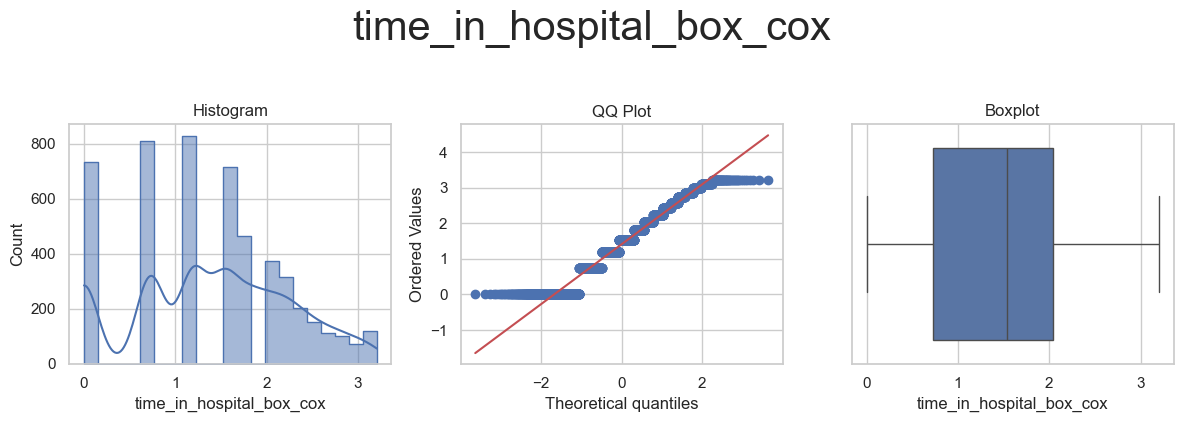

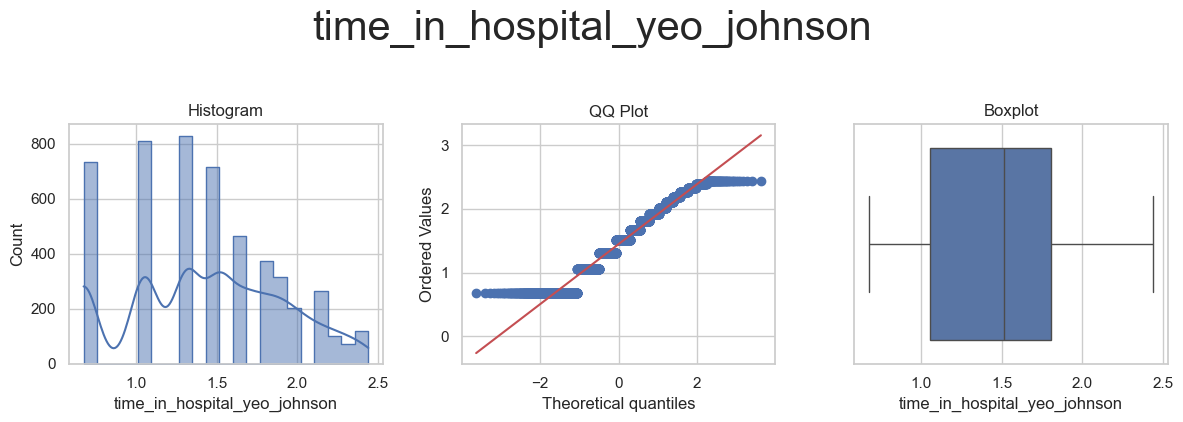



LogTransformer failed for n_procedures: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_procedures: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_procedures: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_procedures: Data must be positive.
* Variable Analyzed: n_procedures
* Applied transformation: ['n_procedures_power', 'n_procedures_yeo_johnson'] 



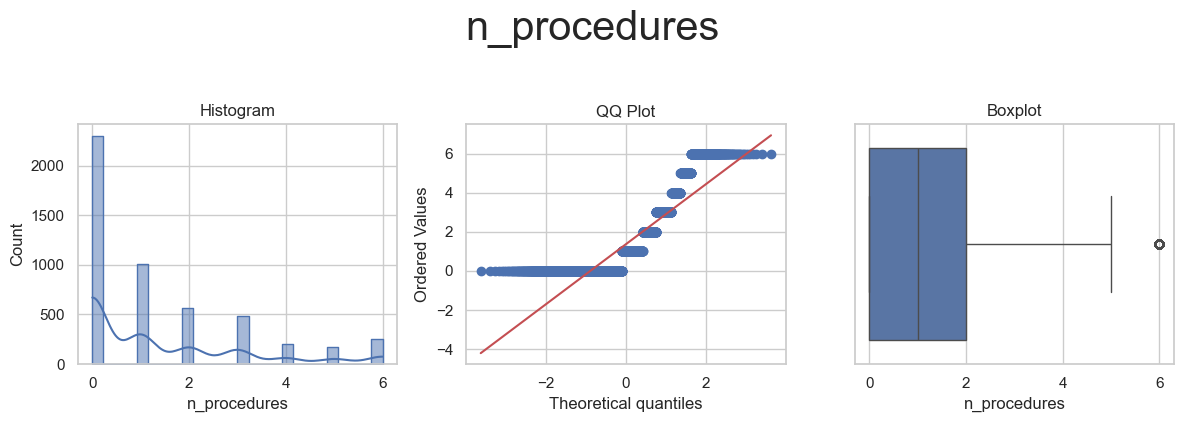

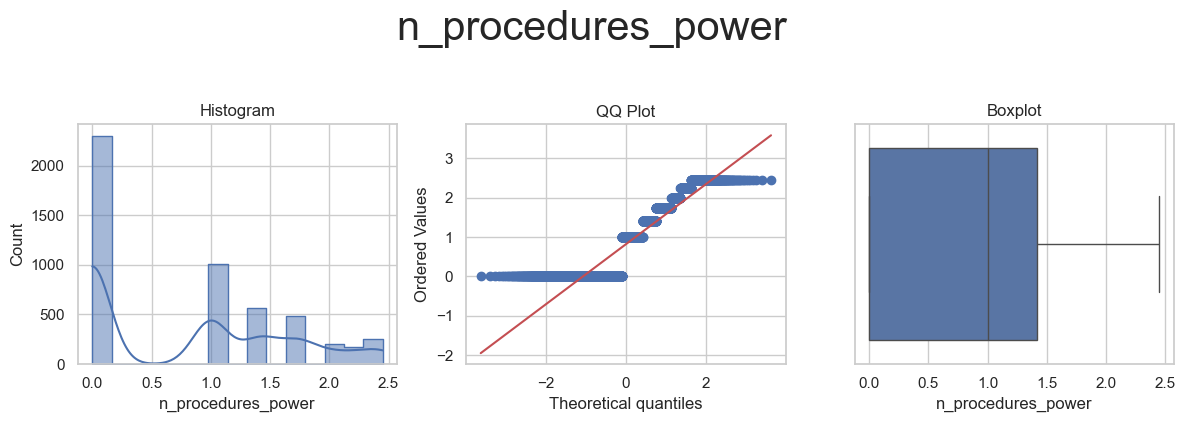

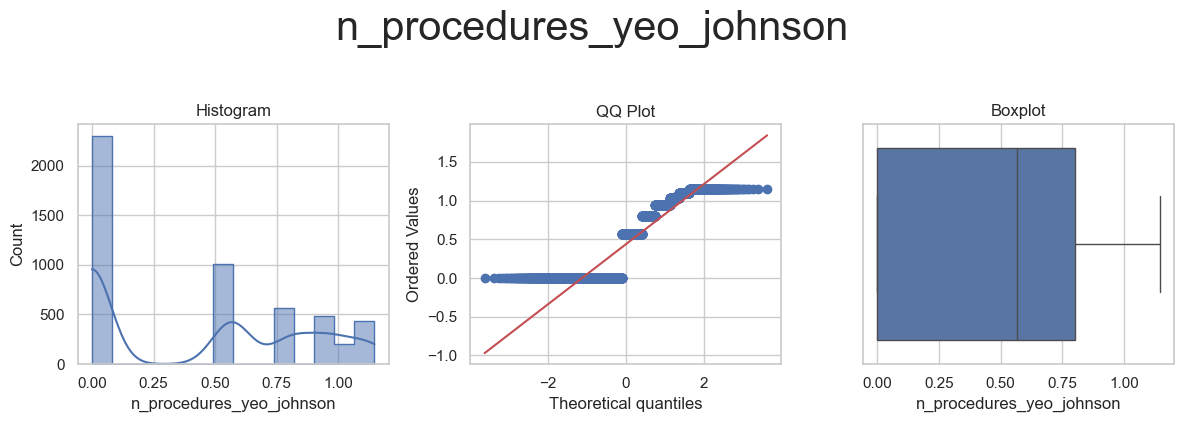



* Variable Analyzed: n_medications
* Applied transformation: ['n_medications_log_e', 'n_medications_log_10', 'n_medications_reciprocal', 'n_medications_power', 'n_medications_box_cox', 'n_medications_yeo_johnson'] 



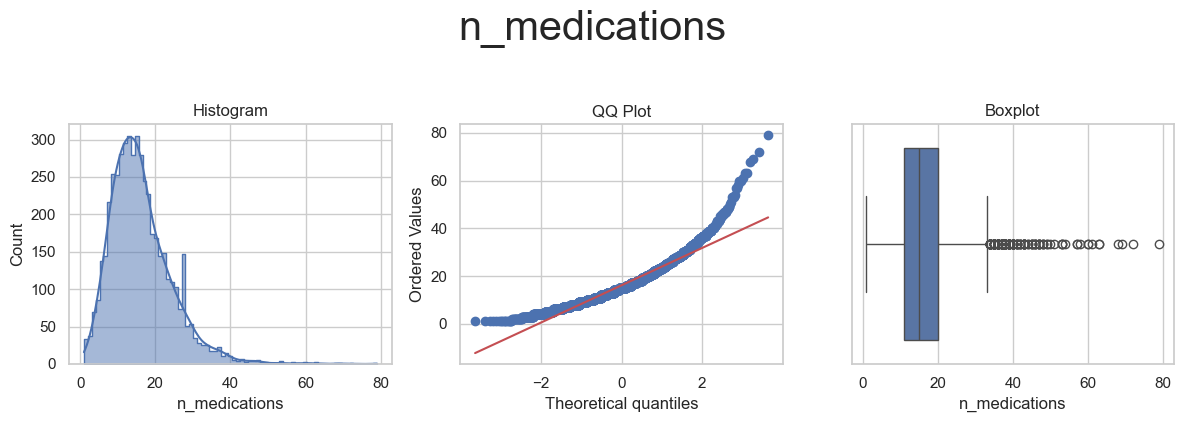

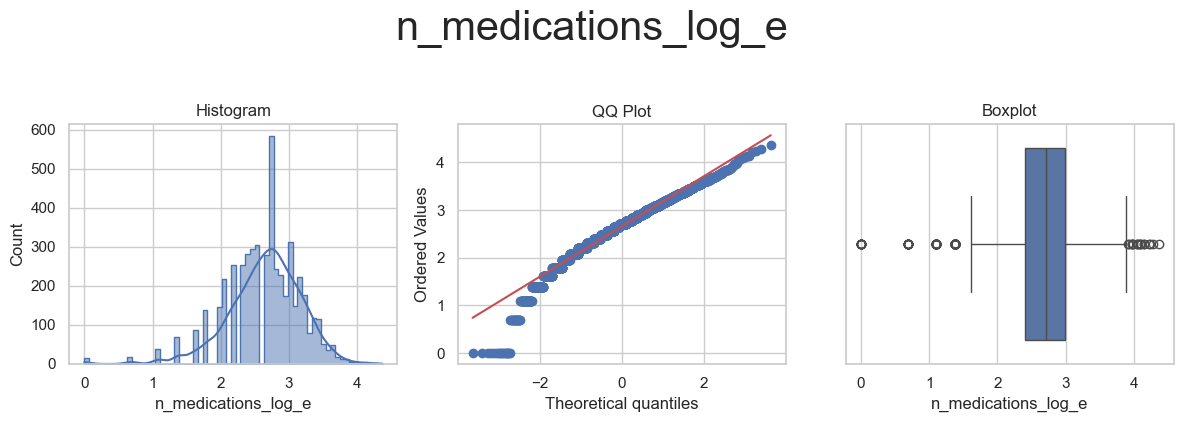

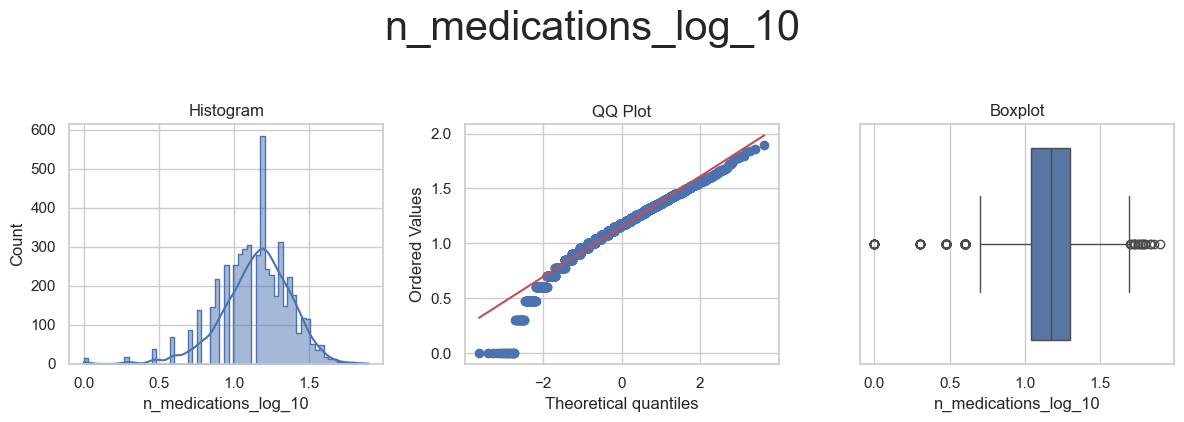

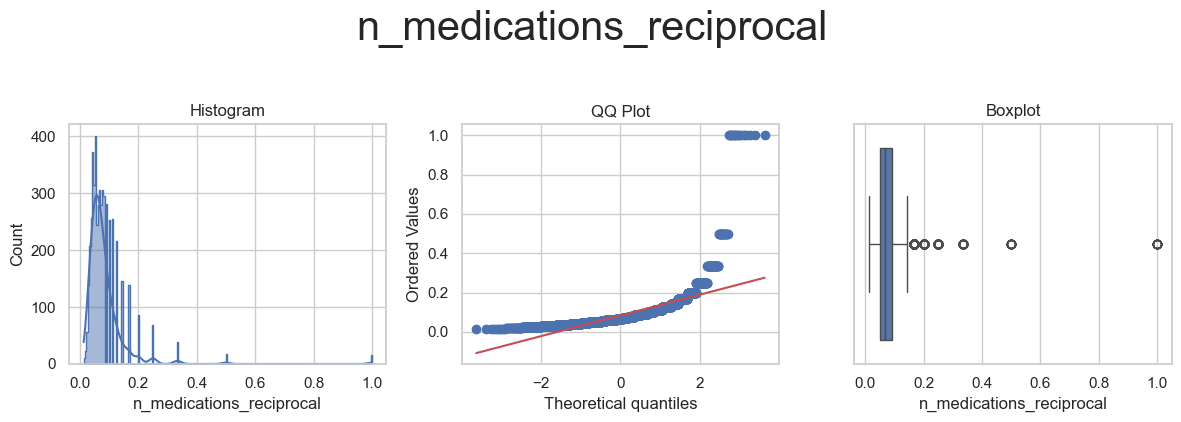

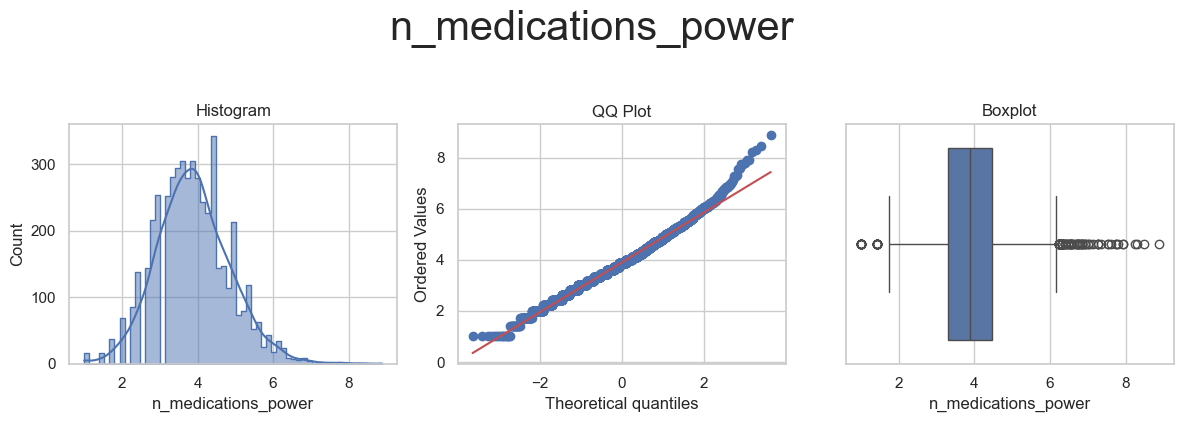

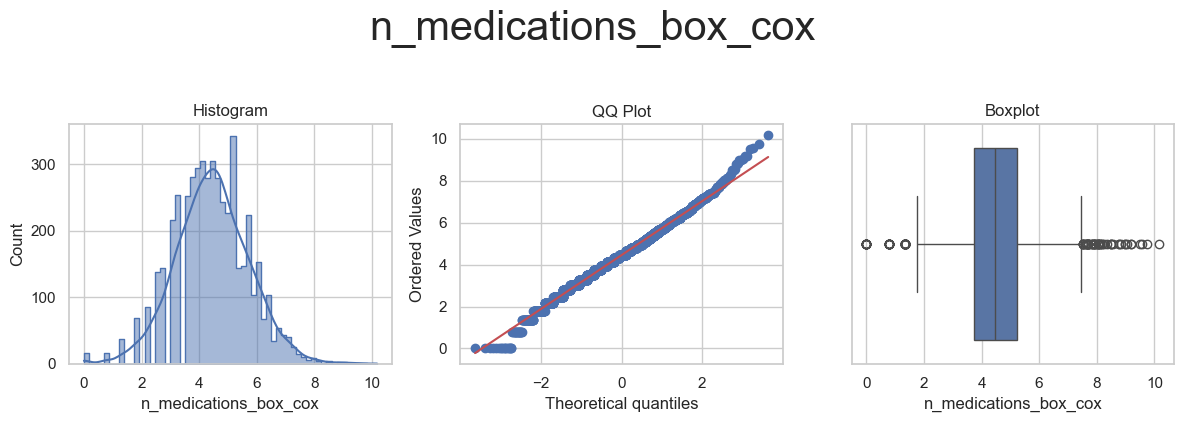

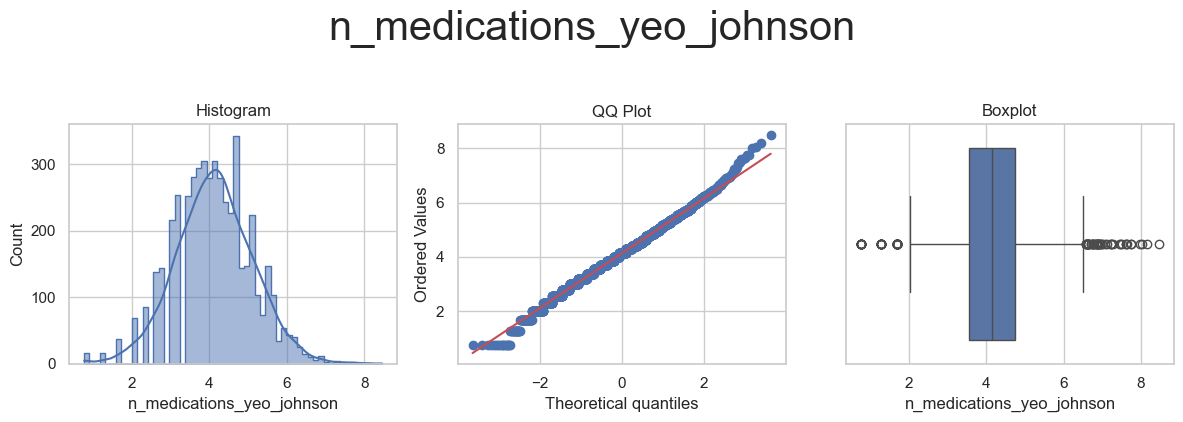



LogTransformer failed for n_outpatient: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_outpatient: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_outpatient: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_outpatient: Data must be positive.
* Variable Analyzed: n_outpatient
* Applied transformation: ['n_outpatient_power', 'n_outpatient_yeo_johnson'] 



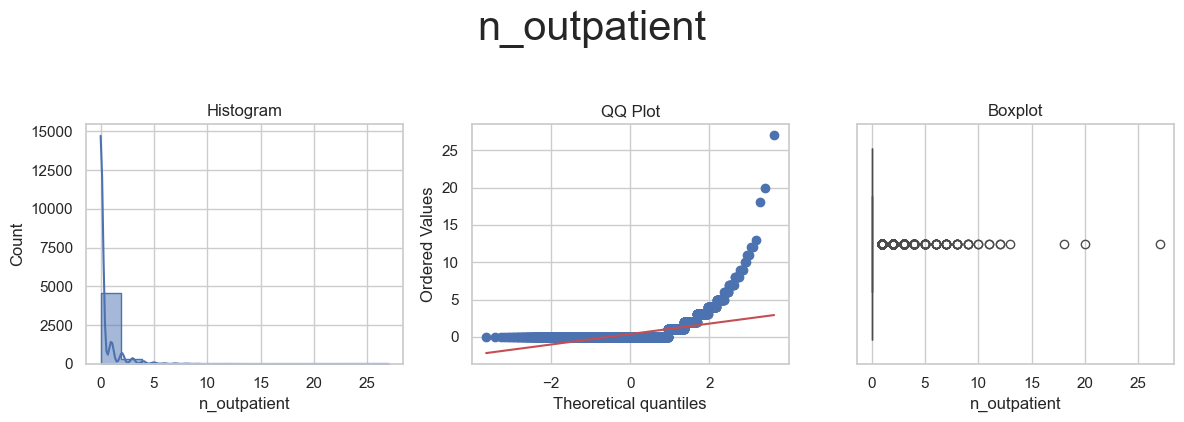

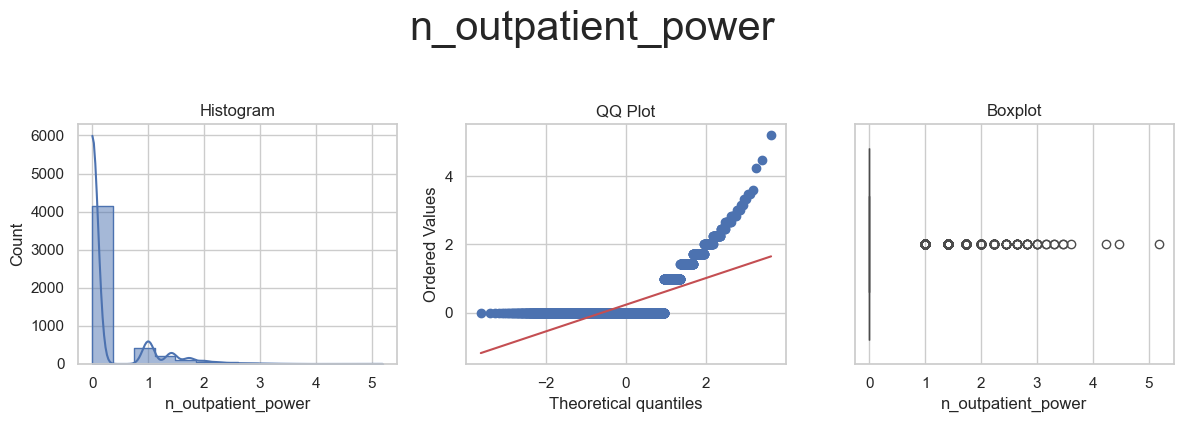

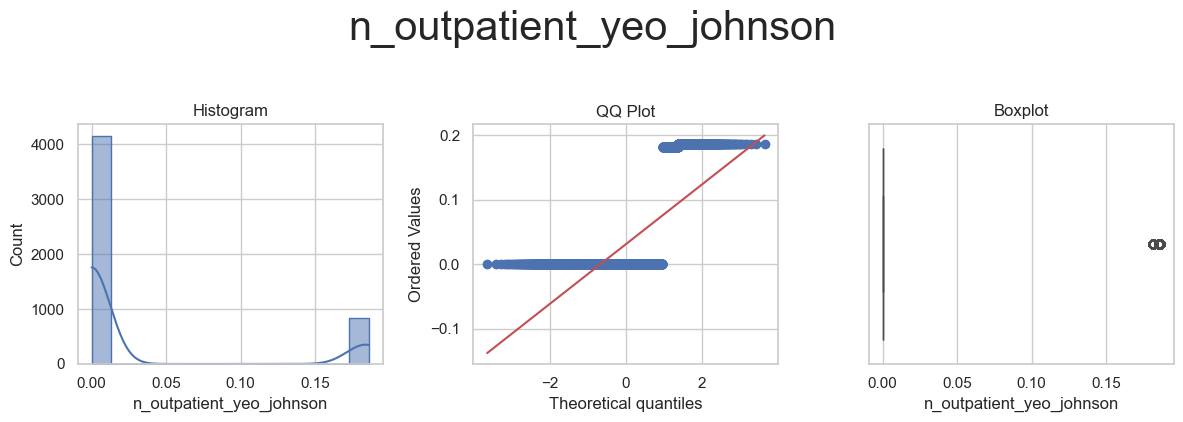



LogTransformer failed for n_inpatient: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_inpatient: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_inpatient: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_inpatient: Data must be positive.
* Variable Analyzed: n_inpatient
* Applied transformation: ['n_inpatient_power', 'n_inpatient_yeo_johnson'] 



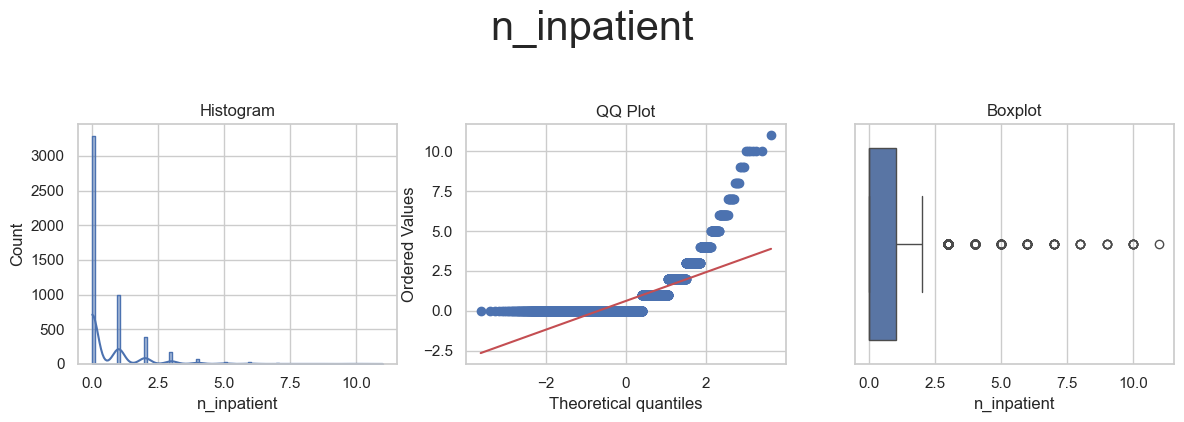

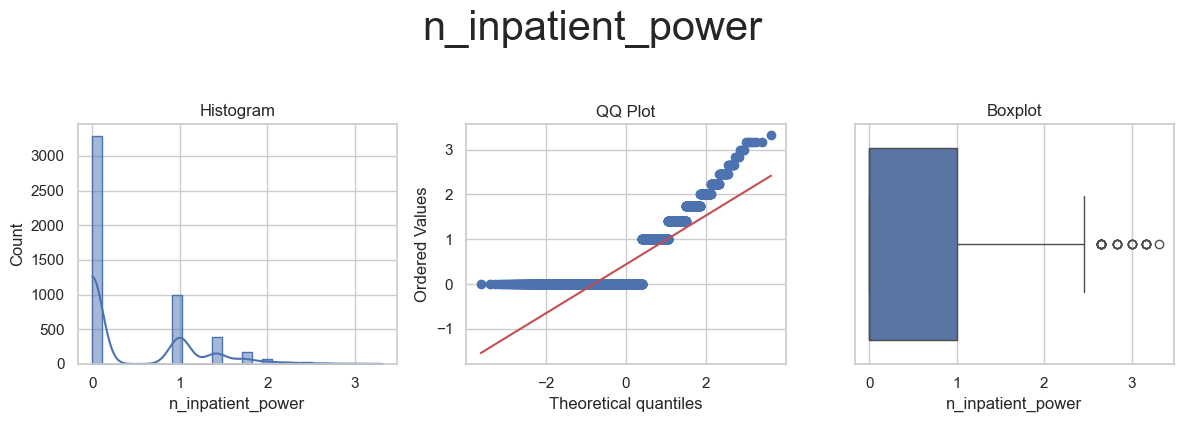

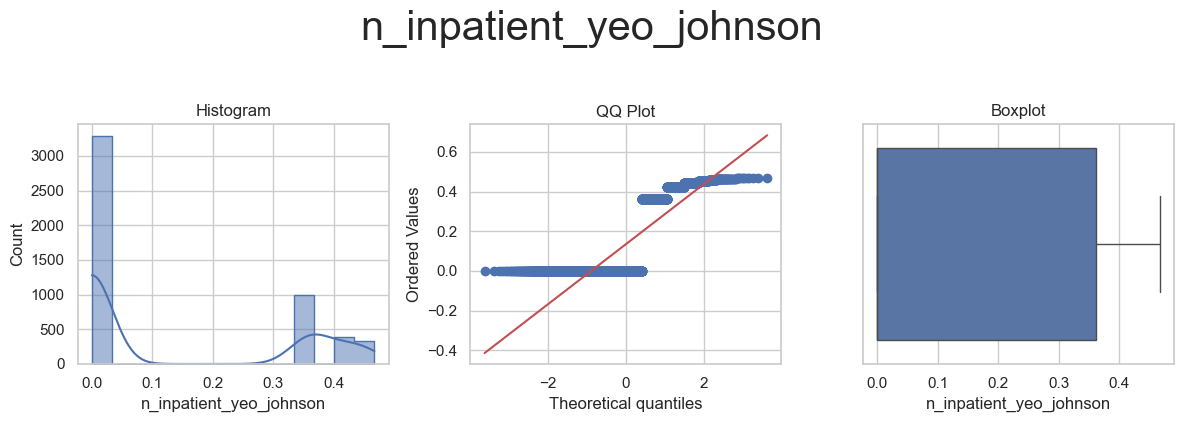



LogTransformer failed for n_emergency: Some variables contain zero or negative values, can't apply log
LogTransformer failed for n_emergency: Some variables contain zero or negative values, can't apply log
ReciprocalTransformer failed for n_emergency: Some variables contain the value zero, can't apply reciprocal transformation.
BoxCoxTransformer failed for n_emergency: Data must be positive.
* Variable Analyzed: n_emergency
* Applied transformation: ['n_emergency_power', 'n_emergency_yeo_johnson'] 



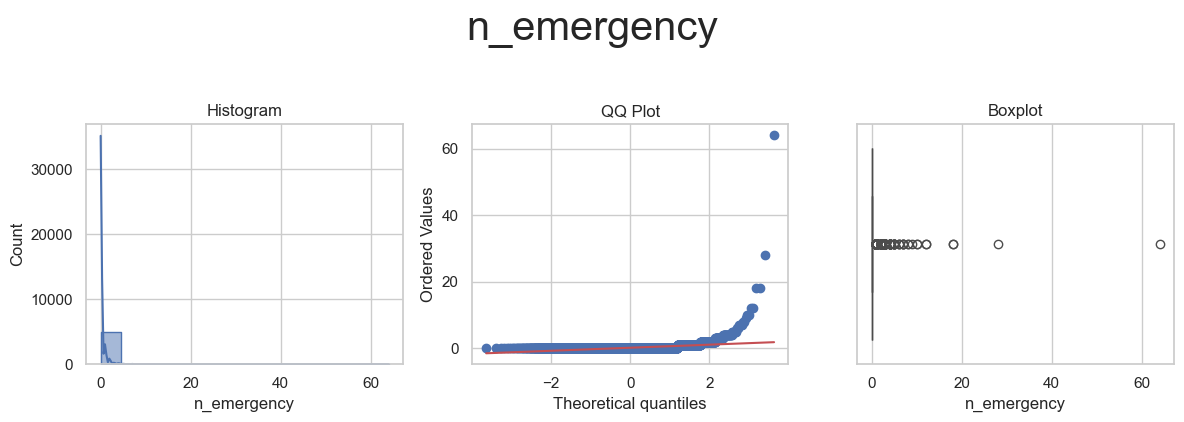

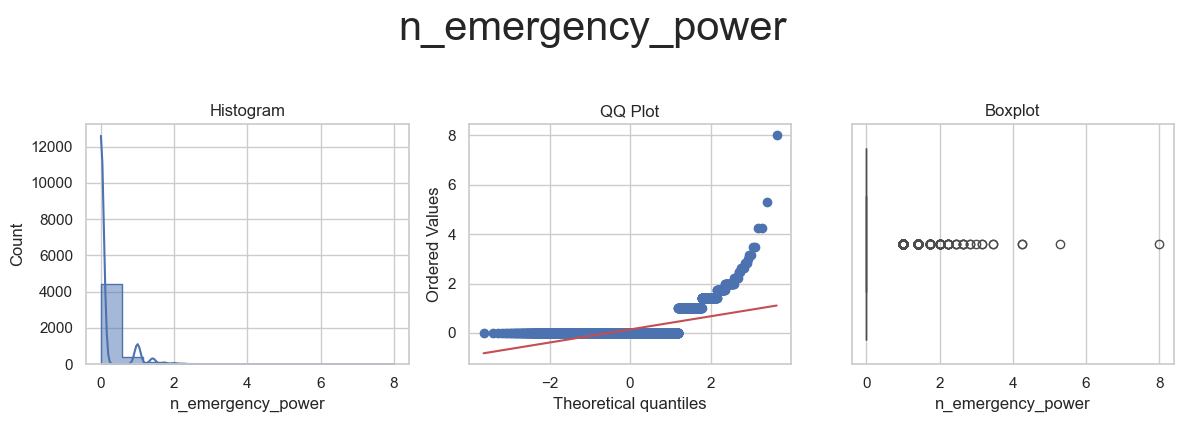

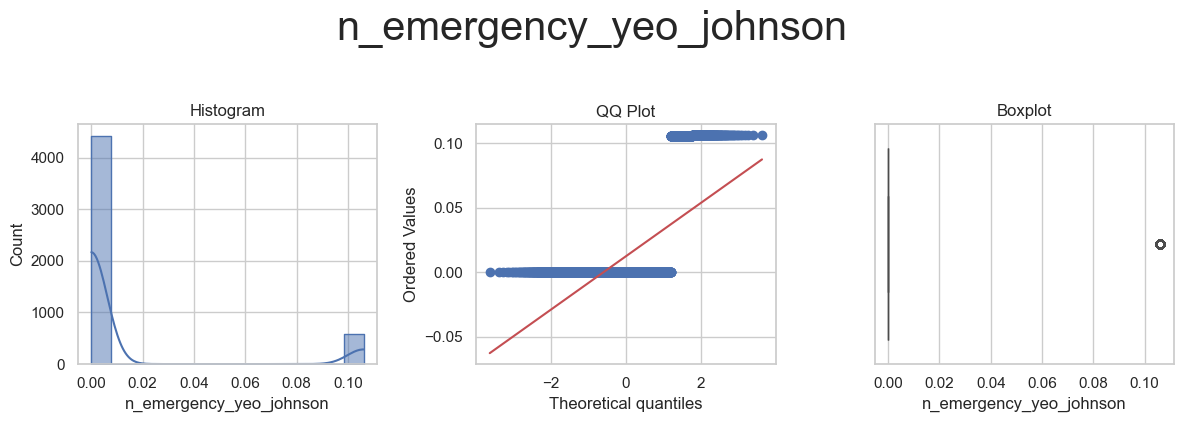

In [20]:
df_num_engineering_2 =FeatureEngineeringAnalysis(df_num_engineering, analysis_type='numerical')

## Smart Correlation

In [21]:
df_smart_engineering = TrainSet.copy()
df_smart_engineering.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 4                47             0             21   
1  [60-70)                 3                50             1             11   
2  [50-60)                 4                66             1             10   
3  [50-60)                14                63             0             28   
4  [50-60)                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency           diag_1       diag_2  \
0             0            1            0            Other        Other   
1             0            0            0  Musculoskeletal  Circulatory   
2             0            0            0            Other        Other   
3             0            0            0      Respiratory  Circulatory   
4             3            2            4            Other     Diabetes   

     diag_3 glucose_test A1Ctest change diabetes_med  readmitted  
0     Other           no      no    yes          yes           1  
1  Diabetes           no      no     no           no           0  
2  Diabetes           no    high     no           no           0  
3  Diabetes       normal      no     no          yes           1  
4     Other           no      no    yes          yes           1

In [22]:
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(variables=None, drop_last=False)
df_ohe = ohe.fit_transform(df_smart_engineering)
print(df_smart_engineering.shape)
df_ohe.head()

(20000, 16)


time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 4                47             0             21   
1                 3                50             1             11   
2                 4                66             1             10   
3                14                63             0             28   
4                 3                60             2             25   

   n_outpatient  n_inpatient  n_emergency  readmitted  age_[70-80)  \
0             0            1            0           1            1   
1             0            0            0           0            0   
2             0            0            0           0            0   
3             0            0            0           1            0   
4             3            2            4           1            0   

   age_[60-70)  ...  glucose_test_no  glucose_test_normal  glucose_test_high  \
0            0  ...                1                    0                  0   
1            1  ...                1                    0                  0   
2            0  ...                1                    0                  0   
3            0  ...                0                    1                  0   
4            0  ...                1                    0                  0   

   A1Ctest_no  A1Ctest_high  A1Ctest_normal  change_yes  change_no  \
0           1             0               0           1          0   
1           1             0               0           0          1   
2           0             1               0           0          1   
3           1             0               0           0          1   
4           1             0               0           1          0   

   diabetes_med_yes  diabetes_med_no  
0                 1                0  
1                 0                1  
2                 0                1  
3                 1                0  
4                 1                0  

[5 rows x 48 columns]

In [30]:
from feature_engine.selection import SmartCorrelatedSelection

corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.25,
                                    selection_method="variance")

corr_sel.fit_transform(df_smart_engineering)
corr_sel.correlated_feature_sets_

[{'n_lab_procedures', 'n_medications', 'time_in_hospital'}]

In [31]:
corr_sel.features_to_drop_

['n_medications', 'time_in_hospital']

---

# Conclusions

## Next steps

In the next workbook we will move to the Modeling step of the CRISP-DM workflow.